In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy import signal
from scipy.stats import norm
from scipy.optimize import curve_fit
import os


import statsmodels.api as sm
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.vector_ar.vecm import coint_johansen


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


import sklearn
from sklearn.neighbors import KernelDensity



## Data preparation for analysis and validation of SF
* SF1 Endogenous and self-sustained growth of output, with persistent fluctuations.
* SF4 Aggregate consumption is less volatile than GDP, and aggregate investments are
more volatile than GDP.
* SF6 Synchronization of the business cycle and emission dynamics.

(Partial) replication of Dosi (2010) fig 1 and 2, Lamperti et al (2018) fig 2 and 8

In [7]:
#SF 1,4,6
#df_1 = pd.read_csv('1234_model.csv')
#print current path
print(os.getcwd())
df_1 = pd.read_csv('../data/1234_model.csv')
T = range(len(df_1.GDP))

def indexnumber(ts):
    return 100 * ts / ts[0]

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Set parameters for bandpass filters
bk_low = 18
bk_high = 96
bk_K = 36

real_GDP_1 = df_1.GDP.iloc[300:].to_numpy() / df_1.p_ep.iloc[300:].to_numpy()
real_C = df_1.total_C.iloc[300:].to_numpy() / df_1.p_ep.iloc[300:].to_numpy()
real_I = df_1.total_I.iloc[300:].to_numpy() / df_1.p_ep.iloc[300:].to_numpy()
#smoothen real_I 
real_I = signal.savgol_filter(real_I, 12, 2)

x = np.arange(0, 361, 60)
years = np.arange(2020, 2051, 5)

gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP_1), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(real_C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(real_I), bk_low, bk_high, bk_K)

Em_filtered = sm.tsa.filters.bkfilter(np.log(df_1.em_index.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df_1.D_ep.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)


T_filter = range(len(gdp_filtered))

/Users/mengeshi/Documents/GitHub/Capsule_Climate/results


/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_19344/3268714683.py:32: RuntimeWarning: divide by zero encountered in log
  Em_filtered = sm.tsa.filters.bkfilter(np.log(df_1.em_index.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_19344/90053511.py:39: RuntimeWarning: divide by zero encountered in log
  ax3.plot(np.log(df_1.em_index.iloc[300:].to_numpy()), label='Em', color=viridis_cmap(0.99))


<Figure size 432x288 with 0 Axes>

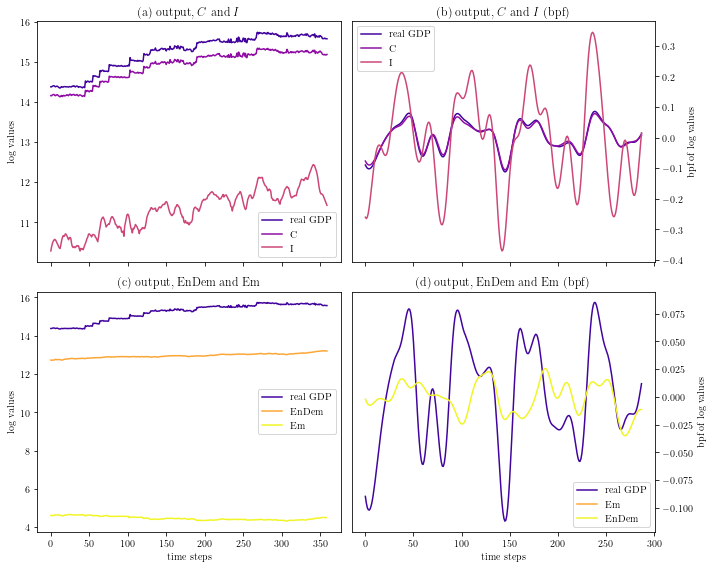

In [10]:
#SF 1,4,6
from matplotlib.cm import get_cmap

#plt.style.use(['science','ieee'])





plt.tight_layout()

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))
viridis_cmap = get_cmap('plasma')


ax1.plot(np.log(real_GDP_1), label='real GDP', color=viridis_cmap(0.1))
ax1.plot(np.log(real_C), label='C', color=viridis_cmap(0.3))
ax1.plot(np.log(real_I), label='I', color=viridis_cmap(0.5))
#remove x axis labels
ax1.set_xticklabels([])
ax1.set_ylabel('log values')
ax1.set_title('(a) output, $C$ and $I$')
ax1.legend()

ax2.plot(gdp_filtered, label='real GDP', color=viridis_cmap(0.1))
ax2.plot(C_filtered, label='C', color=viridis_cmap(0.3))
ax2.plot(I_filtered, label='I', color=viridis_cmap(0.5))
#put axis labels to the right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
#axis labels to the right as well 
ax2.set_xticklabels([])
ax2.set_ylabel('bpf of log values')
ax2.set_title('(b) output, $C$ and $I$ (bpf)')
ax2.legend()

ax3.plot(np.log(real_GDP_1), label='real GDP', color=viridis_cmap(0.1))
ax3.plot(np.log(df_1.D_ep.iloc[300:].to_numpy()), label='EnDem', color=viridis_cmap(0.8))
ax3.plot(np.log(df_1.em_index.iloc[300:].to_numpy()), label='Em', color=viridis_cmap(0.99))
ax3.set_xlabel('time steps')
ax3.set_ylabel('log values')
ax3.set_title('(c) output, EnDem and Em')
ax3.legend()

ax4.plot(gdp_filtered, label='real GDP', color=viridis_cmap(0.1))
ax4.plot(Em_filtered, label='Em', color=viridis_cmap(0.8))
ax4.plot(EnDem_filtered, label='EnDem', color=viridis_cmap(0.99))
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.set_xlabel('time steps')
ax4.set_ylabel('bpf of log values')
ax4.set_title('(d) output, EnDem and Em (bpf)')
ax4.legend()

plt.tight_layout()
#plt.savefig('../validation/timeseries_gdp.pdf', bbox_inches='tight')
plt.show()



## Data Preperation and SF 12, 5
* SF12  labor income share is anti-cyclical
* SF5  cross correlations of a large number of outputs and real GDP 

In [12]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as smt
import matplotlib.pyplot as plt


def compute_avg_correlations(df_list, indicator, min_lag=-9, max_lag=9, y='GDP'):
    all_corr = []
    
    for df in df_list:
        # Prepare GDP data
        real_GDP = df[y].to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), 6, 32, 8)
        
        # Prepare indicator data
        ind_data = df[indicator].to_numpy()
        
        # Trim data to make sure they have the same length
        min_len = min(len(gdp_filtered), len(ind_data))
        gdp_filtered = gdp_filtered[-min_len:]
        ind_data = ind_data[-min_len:]
        
        # Compute cross-correlations
        ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
        ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
        ccf = np.concatenate((ccf_back, ccf_forw))
        
        all_corr.append(ccf)
    
    avg_corr = np.mean(np.array(all_corr), axis=0)
    return avg_corr


def load_dataframes_from_folder(folder_path, start_index=300):
    df_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith('model.csv'):
            df = pd.read_csv(os.path.join(folder_path, filename)).iloc[start_index:]
            df_list.append(df)
    return df_list



# #SF 12, 5
# def filepath(i):
#     return f'15 Data/{i}_model.csv'

# # n_MC = 100
# n_MC = 9


# for MC_i in range(1235, n_MC + 1235):
#     #df_list.append(pd.read_csv(filepath(MC_i)).iloc[550:650])
#     df_list.append(pd.read_csv(filepath(MC_i)).iloc[300:])
#     #FIXME adjust sampling window
# df = pd.concat(df_list)

#no limits to head() number of colums
# pd.set_option('display.max_columns', None)
# df.head()

# noise_level = 1e-1
# df['U'] += np.random.normal(0, noise_level, df['U'].shape[0])
# df['N_goods'] += np.random.normal(0, noise_level, df['N_goods'].shape[0])
# df['em_index'] += np.random.normal(0, noise_level, df['em_index'].shape[0])

#is 'U' in the df?
#'U' in df.columns
#df_list = pd.read_csv('1234_model.csv')'
#print head of df_list
#df_list[1].head()

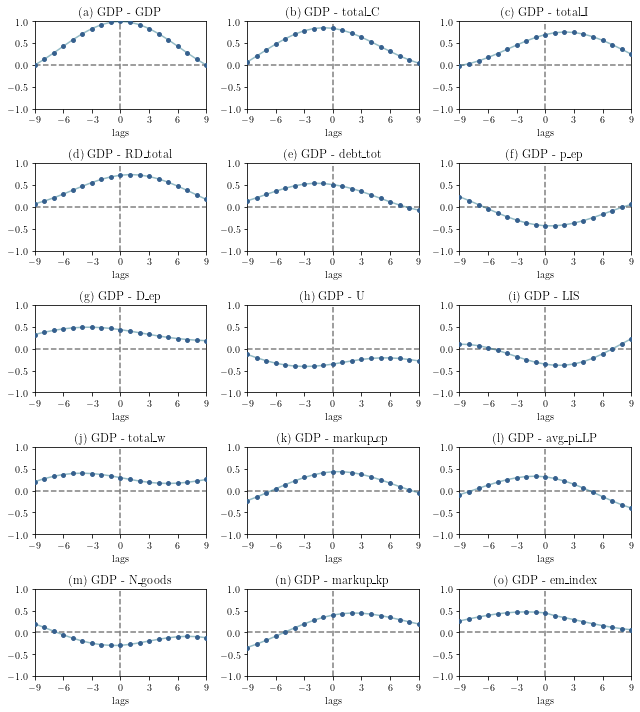

In [16]:
#SF 12, 5
from matplotlib.cm import get_cmap
import statsmodels.api as sm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as smt
import matplotlib.pyplot as plt



def compute_correlations(indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP'):

    all_corr = []

    for df_part in df_list:

        # Apply filter
        if make_real_y:
            real_GDP =  df_part[y].to_numpy() / df_part.p_ep.to_numpy()
        else:
            real_GDP =  df_part[y].to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)

        # Prepare data
        ind_data = df_part[indicator].to_numpy()

        if indicator == 'inventories':
            ind_data = ind_data / (df_part['total_C'].to_numpy() / df_part['p_ep'].to_numpy())
        
        if make_real:
            ind_data = ind_data / df_part.p_ep.to_numpy()

        if apply_bk:
            ind_data = sm.tsa.filters.bkfilter(np.log(ind_data), bk_low, bk_high, bk_K)

        ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
        ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
        ccf = np.concatenate((ccf_back, ccf_forw))

        all_corr.append([ccf])

    avg_corr = np.transpose(np.mean(np.array(all_corr), axis=0))

    return avg_corr

# Modified function to perform the analysis on just one of the time series in the list
def compute_correlations_single_series(df_new, indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP', series_index=1):
    """
    This function performs cross-correlation analysis on a single time series from the list of dataframes.

    Parameters:
        - df_list (list): List of dataframes containing the data
        - indicator (str): Name of the indicator column
        - apply_bk (bool): Whether to apply Baxter-King filter to the indicator
        - make_real (bool): Whether to adjust the indicator for inflation/price level
        - make_real_y (bool): Whether to adjust the target (usually GDP) for inflation/price level
        - min_lag (int): Minimum lag for cross-correlation
        - max_lag (int): Maximum lag for cross-correlation
        - y (str): Name of the target column, defaults to 'GDP'
        - series_index (int): Index of the time series to analyze from the list. Defaults to the first one (0).

    Returns:
        - ccf (numpy.ndarray): Cross-correlation values
    """
    
    # Fetch the specific dataframe from the list using the index
    df_part = df_new
    
    # Apply filter to the target (usually GDP)
    if make_real_y:
        real_GDP = df_part[y].to_numpy() / df_part['p_ep'].to_numpy()
    else:
        real_GDP = df_part[y].to_numpy()
    gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)
    
    # Prepare the indicator data
    ind_data = df_part[indicator].to_numpy()
    if indicator == 'inventories':
        ind_data = ind_data / (df_part['total_C'].to_numpy() / df_part['p_ep'].to_numpy())
    if make_real:
        ind_data = ind_data / df_part['p_ep'].to_numpy()
    if apply_bk:
        ind_data = sm.tsa.filters.bkfilter(np.log(ind_data), bk_low, bk_high, bk_K)
    
    # Compute cross-correlation
    ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
    ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
    ccf = np.concatenate((ccf_back, ccf_forw))
    
    return ccf

def safe_log(arr):
    """Compute the logarithm where arr > 0, leave other values untouched."""
    result = np.empty_like(arr)
    mask = arr > 0
    result[mask] = np.log(arr[mask])
    result[~mask] = arr[~mask]  # Leave zero or negative values untouched
    return result

def safe_std(arr):
    """Compute the standard deviation where arr is not NaN, leave other values untouched."""
    mask = ~np.isnan(arr)
    if np.any(mask):
        return np.std(arr[mask])
    return np.nan

def compute_correlations_single_series_robust(df, indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP'):
    if make_real_y:
        real_GDP = df[y].to_numpy() / df['p_ep'].to_numpy()
    else:
        real_GDP = df[y].to_numpy()
        
    gdp_filtered = sm.tsa.filters.bkfilter(safe_log(real_GDP), bk_low, bk_high, bk_K)

    
    ind_data = df[indicator].to_numpy()
    
    if indicator == 'inventories':
        ind_data = ind_data / (df['total_C'].to_numpy() / df['p_ep'].to_numpy())
        
    if make_real:
        ind_data = ind_data / df['p_ep'].to_numpy()
        
    if apply_bk:
        ind_data = sm.tsa.filters.bkfilter(safe_log(ind_data), bk_low, bk_high, bk_K)

    
    # Compute cross-correlation using safe standard deviation calculation
    ccf_back = np.correlate(gdp_filtered[::-1] - np.mean(gdp_filtered), ind_data[::-1] - np.mean(ind_data), 'full') / (safe_std(gdp_filtered) * safe_std(ind_data) * len(gdp_filtered))
    ccf_forw = np.correlate(gdp_filtered - np.mean(gdp_filtered), ind_data - np.mean(ind_data), 'full') / (safe_std(gdp_filtered) * safe_std(ind_data) * len(gdp_filtered))
    
    # Only keep the relevant lags
    ccf_back = ccf_back[len(gdp_filtered)-1:-min_lag][::-1]
    ccf_forw = ccf_forw[len(gdp_filtered)-1:max_lag+1]
    
    ccf = np.concatenate((ccf_back, ccf_forw))
    
    # # Check for zero-size array or NaN values and handle them
    # if ccf.size == 0 or np.isnan(ccf).all():
    #     return np.array([0])  # return an array of zero if ccf is empty or all NaNs
    
    # # Normalize the ccf values to fit within [-1, 1]
    # ccf = ccf / np.max(np.abs(ccf))
    
    return ccf

def compute_correlations_final(df_new, indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP', series_index=1):
    """
    This function performs cross-correlation analysis on a single time series from the list of dataframes.

    Parameters:
        - df_list (list): List of dataframes containing the data
        - indicator (str): Name of the indicator column
        - apply_bk (bool): Whether to apply Baxter-King filter to the indicator
        - make_real (bool): Whether to adjust the indicator for inflation/price level
        - make_real_y (bool): Whether to adjust the target (usually GDP) for inflation/price level
        - min_lag (int): Minimum lag for cross-correlation
        - max_lag (int): Maximum lag for cross-correlation
        - y (str): Name of the target column, defaults to 'GDP'
        - series_index (int): Index of the time series to analyze from the list. Defaults to the first one (0).

    Returns:
        - ccf (numpy.ndarray): Cross-correlation values
    """
    
    # Fetch the specific dataframe from the list using the index
    df_part = df_new

    #ignore the first 300 time steps
    df_part = df_part.iloc[300:]
    
    # Apply filter to the target (usually GDP)
    if make_real_y:
        real_GDP = df_part[y].to_numpy() / df_part['p_ep'].to_numpy()
    else:
        real_GDP = df_part[y].to_numpy()
    gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)
    
    # Prepare the indicator data
    ind_data = df_part[indicator].to_numpy()
    if indicator == 'inventories':
        ind_data = ind_data / (df_part['total_C'].to_numpy() / df_part['p_ep'].to_numpy())
    if make_real:
        ind_data = ind_data / df_part['p_ep'].to_numpy()
    if apply_bk:
        ind_data = sm.tsa.filters.bkfilter(np.log(ind_data), bk_low, bk_high, bk_K)
    
    # Compute cross-correlation
    ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
    ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
    ccf = np.concatenate((ccf_back, ccf_forw))
    
    return ccf

'''
# Example of how to call the function
# ccf_result = compute_correlations_single_series(df_list, 'total_C', series_index=0)
# print(ccf_result)

#open csv as df from location '25 Data/2345_model.csv'
# df_new = pd.read_csv('25 Data/2345_model.csv')

# lags = 9
# min_lag = -lags
# max_lag = lags

# indicators = ['GDP', 'total_C', 'total_I', 'RD_total', 'debt_tot', 'p_ep', 'D_ep', 
#               'U', 'LIS', 'total_w',  'markup_cp', 'avg_pi_LP', 'N_goods', 'markup_kp','em_index']
# # indicators = ['GDP', 'total_C', 'I', 'U', 'EnDem', 'Em']
# lags = np.arange(min_lag, max_lag + 1)


# #plt.style.use(['science','ieee'])
# custom_cmap = get_cmap('viridis')
# plt.tight_layout()




# fig, axes = plt.subplots(5, 3, figsize=(9, 10))

# for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):

#     fig_nr = chr(i + 97)

#     title = indicator

#     apply_bk = True
#     make_real = True

#     if indicator in ['markups', 'D_ep', 'carbon_emissions', 'LIS', 'total_w', 'p_ep', 'avg_π_LP', 'inventories']:
#         make_real=False
#         if indicator == 'total_w':
#             title = 'nominal wages'
#         elif indicator == 'avg_π_LP':
#             title = '$\\bar{LP}$'
#         elif indicator == 'inventories':
#             title = 'Ivt-Sales'

#     if indicator == 'real wages':
#         indicator = 'wages'
        
#     # if indicator in ['U', 'N_goods', 'em_index']:
#     #     all_r = compute_correlations_single_series(df_list, indicator, min_lag=min_lag, max_lag=max_lag, y='GDP')
#     # else:
#     all_r = compute_correlations_single_series(df_new, indicator, apply_bk=apply_bk, make_real=make_real,
#                                         min_lag=min_lag, max_lag=max_lag)

#     ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='grey')
#     ax.vlines(0, -1., 1, linestyle='dashed', color='grey')

#     print(len(lags), len(all_r))

#     ax.scatter(lags, all_r, color=custom_cmap(0.3), zorder=10, s=15)
#     ax.plot(lags, all_r, alpha=0.5, color=custom_cmap(0.4), zorder=9)

#     ax.set_ylim(-1., 1.)
#     ax.set_xlim(min_lag, max_lag)
#     ax.set_xticks(np.linspace(min_lag, max_lag, 7))
#     ax.set_yticks(np.linspace(-1, 1, 5))
#     ax.set_title(f'({fig_nr}) GDP - {title}')
#     ax.set_xlabel('lags')

# plt.tight_layout()
# # plt.savefig('../../plotting/validation/cross_correlations_short.pdf', bbox_inches='tight')
# plt.show()
'''

df_new = pd.read_csv('../data/1234_model.csv')

epsilon = 1e-9  # Small value for shifting
df_new['U'] += epsilon * (df_new['U'] == 0)
df_new['N_goods'] += epsilon * (df_new['N_goods'] == 0)
df_new['em_index'] += epsilon * (df_new['em_index'] == 0)

lags = 9
min_lag = -lags
max_lag = lags
indicators = ['GDP', 'total_C', 'total_I', 'RD_total', 'debt_tot', 'p_ep', 'D_ep', 
              'U', 'LIS', 'total_w',  'markup_cp', 'avg_pi_LP', 'N_goods', 'markup_kp','em_index']
lags = np.arange(min_lag, max_lag + 1)

custom_cmap = get_cmap('viridis')

fig, axes = plt.subplots(5, 3, figsize=(9, 10))

for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):
    fig_nr = chr(i + 97)
    title = indicator
    apply_bk = True
    make_real = True

    if indicator in ['markups', 'D_ep', 'carbon_emissions', 'LIS', 'total_w', 'p_ep', 'avg_π_LP', 'inventories']:
        make_real = False

    all_r = compute_correlations_final(df_new, indicator, apply_bk=apply_bk, make_real=make_real,
                                       min_lag=min_lag, max_lag=max_lag)

    ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='grey')
    ax.vlines(0, -1., 1, linestyle='dashed', color='grey')

    ax.scatter(lags, all_r, color=custom_cmap(0.3), zorder=10, s=15)
    ax.plot(lags, all_r, alpha=0.5, color=custom_cmap(0.4), zorder=9)

    ax.set_ylim(-1., 1.)
    ax.set_xlim(min_lag, max_lag)
    ax.set_xticks(np.linspace(min_lag, max_lag, 7))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_title(f'({fig_nr}) GDP - {title}')
    ax.set_xlabel('lags')

plt.tight_layout()
plt.show()

## Data Preparation SF 11 

* income and wealth Distributions

In [123]:
def powerlaw(x, alpha, beta):
    return beta * x ** (-1 - alpha)

df_I_W = pd.read_csv('final_income_dists.csv')

start_60 = round(20/100 * 2500)
end_60 = round(80/100 * 2500)

I_sorted = np.sort(df_I_W.all_I.to_numpy())
I_share = sum(I_sorted[start_60:end_60]) / sum(I_sorted)
print("I share:", I_share)

W_sorted = np.sort(df_I_W.all_W.to_numpy())
W_share = sum(W_sorted[start_60:end_60]) / sum(W_sorted)
print("W share:", W_share)

I share: 0.5650131118400974
W share: 0.4672349137717755


/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_96944/1833508047.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = get_cmap('viridis')


<Figure size 1980x1500 with 0 Axes>

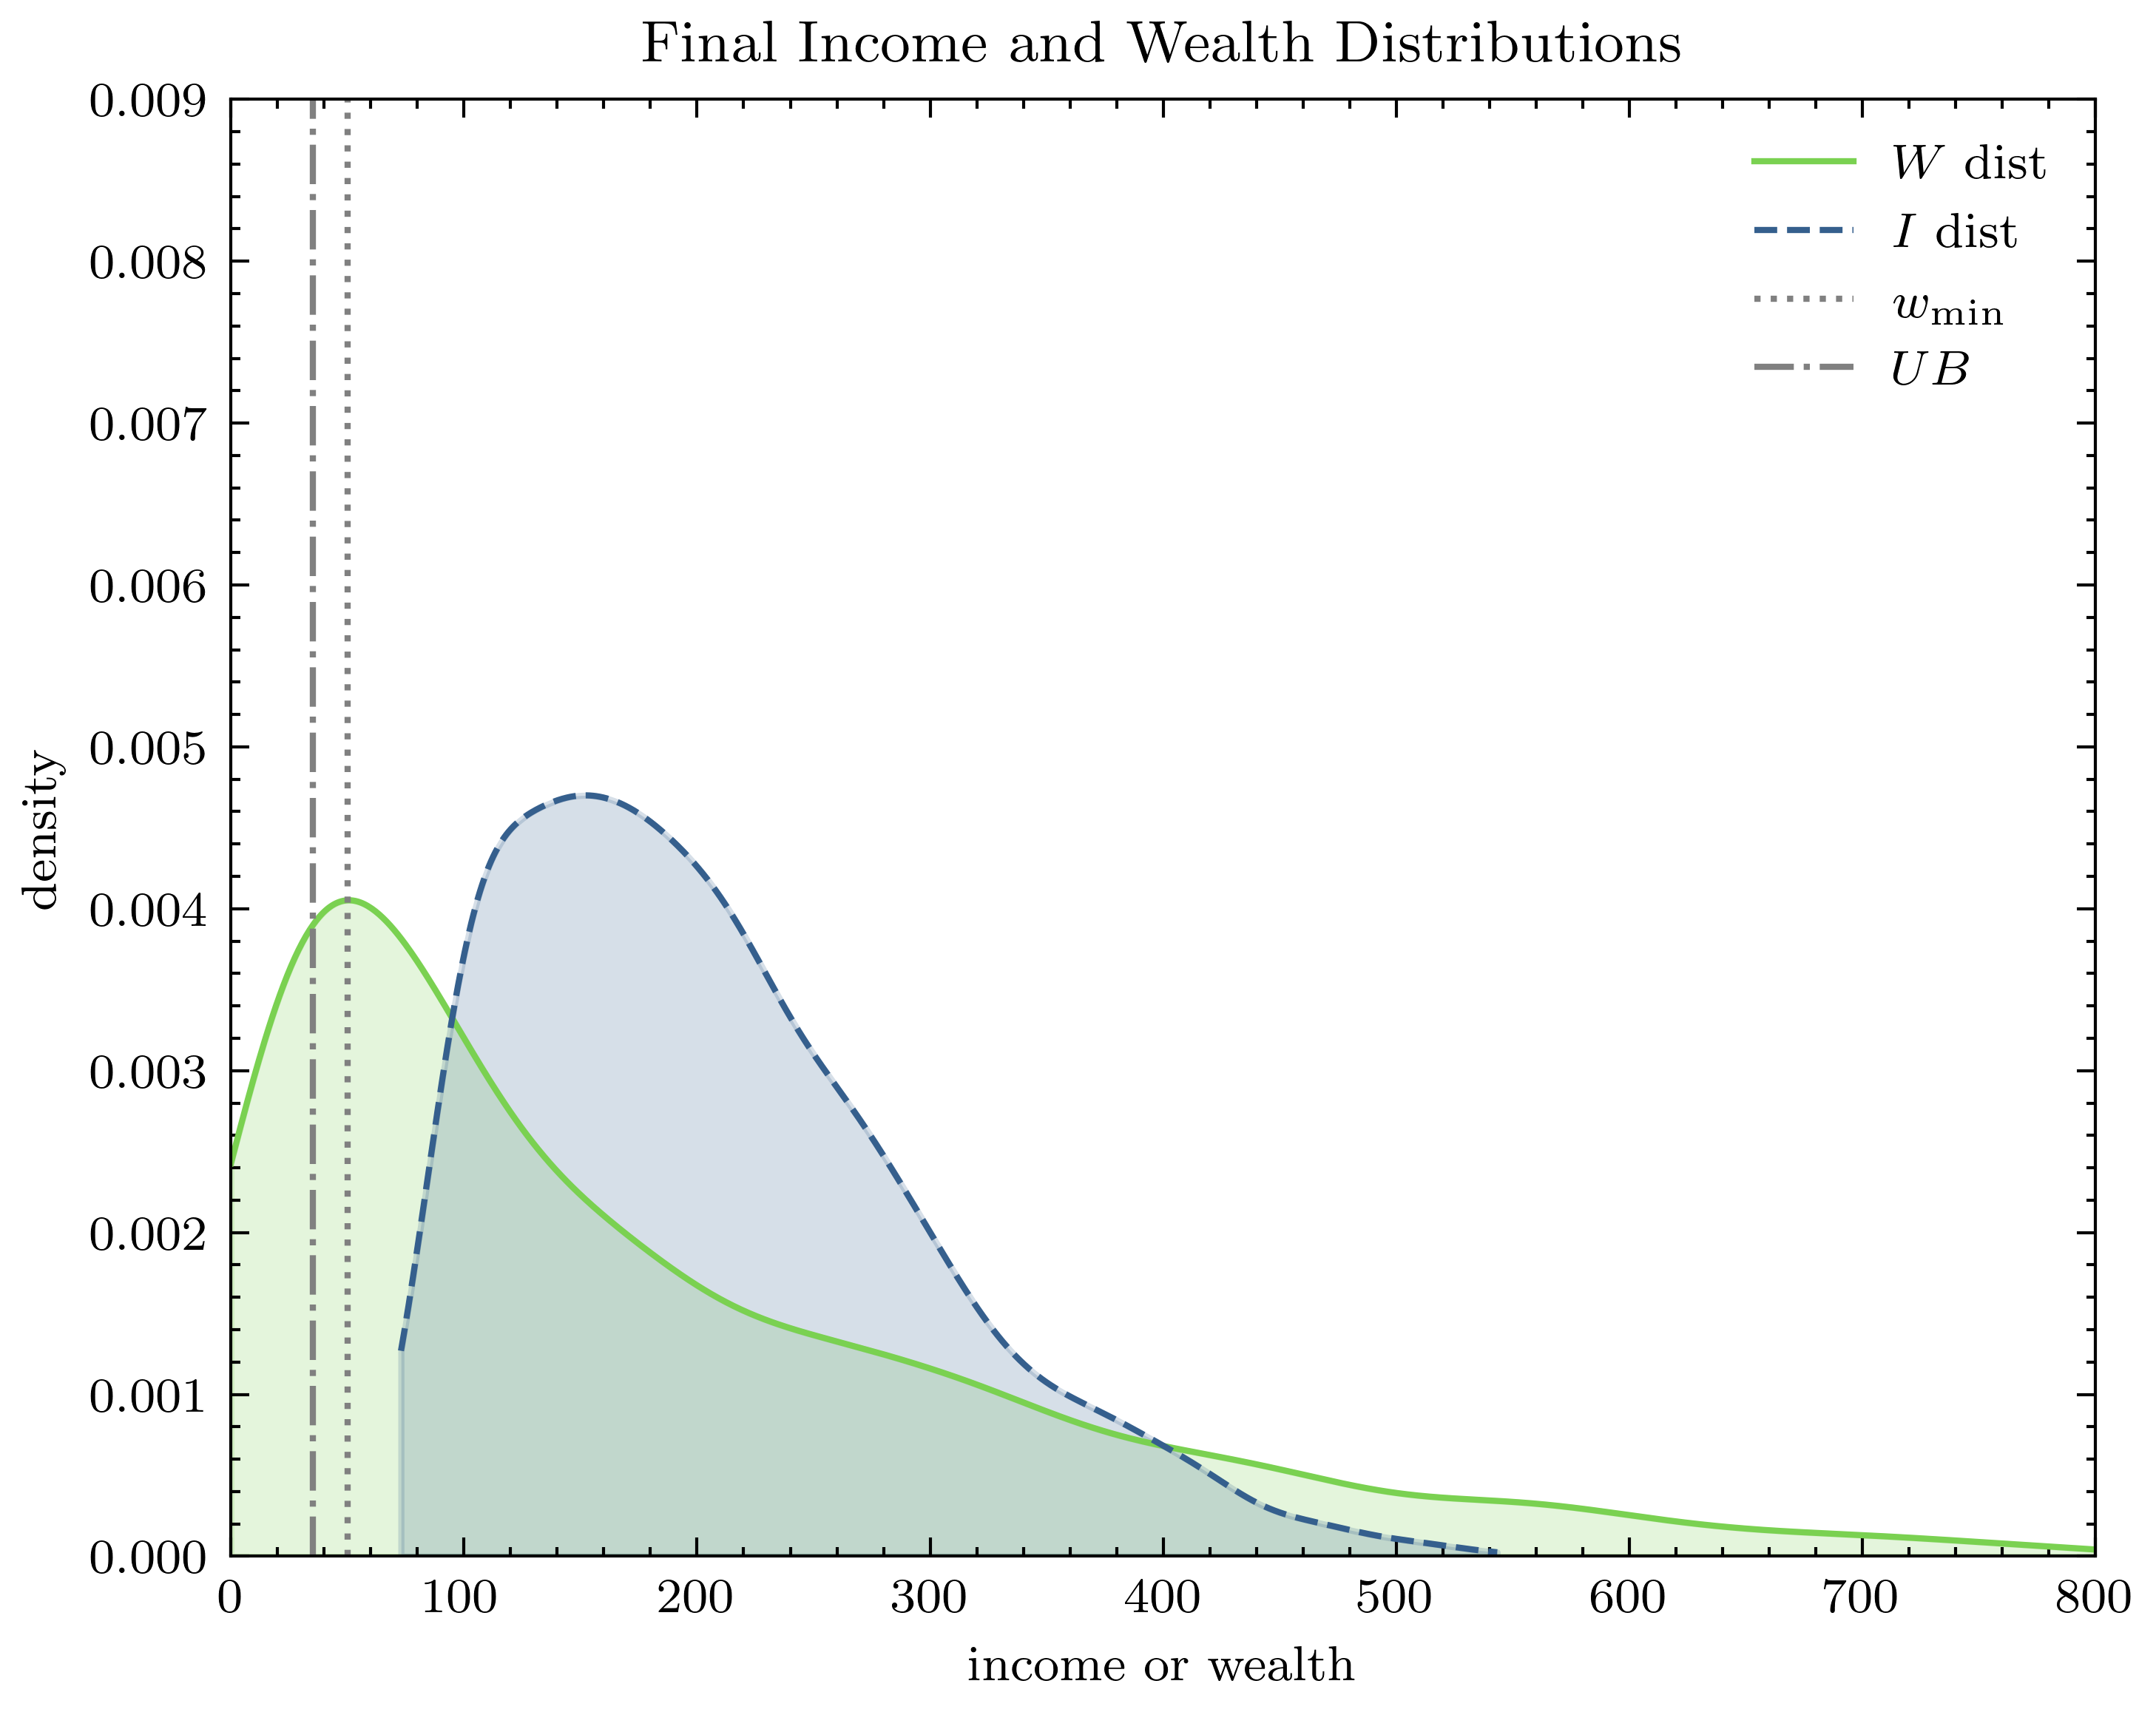

In [125]:

plt.style.use(['science','ieee'])
plt.tight_layout()

custom_cmap = get_cmap('viridis')


fig, ax = plt.subplots(figsize=(5, 4))

kde = stats.gaussian_kde(df_I_W.all_W.to_numpy())

W_range = np.linspace(min(df_I_W.all_W), max(df_I_W.all_W), 1000)
prob = kde(W_range)

ax.plot(W_range, prob, label='$W$ dist', color=custom_cmap(0.8))
ax.fill_between(W_range, prob, alpha=0.2, color=custom_cmap(0.8))

kde = stats.gaussian_kde(df_I_W.all_I.to_numpy())

I_range = np.linspace(min(df_I_W.all_I), max(df_I_W.all_I), 1000)
prob = kde(I_range)

ax.plot(I_range, prob, label='$I$ dist', color=custom_cmap(0.3))
ax.fill_between(I_range, prob, alpha=0.2, color=custom_cmap(0.3))

ax.set_xlim(0, 800)
ax.set_ylim(0.0, 0.009)
ax.set_xlabel('income or wealth')
ax.set_ylabel('density')
#title
ax.set_title('Final Income and Wealth Distributions')

ax.axvline(50, c='grey', linestyle='dotted', label='$w_{\min}$')
ax.axvline(35, c='grey', linestyle='dashdot', label='$UB$')
ax.legend()

plt.tight_layout()
#plt.savefig('../../plotting/validation/I_W_dist.pdf', bbox_inches='tight')
plt.show()

/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_96944/3664947952.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = get_cmap('viridis')


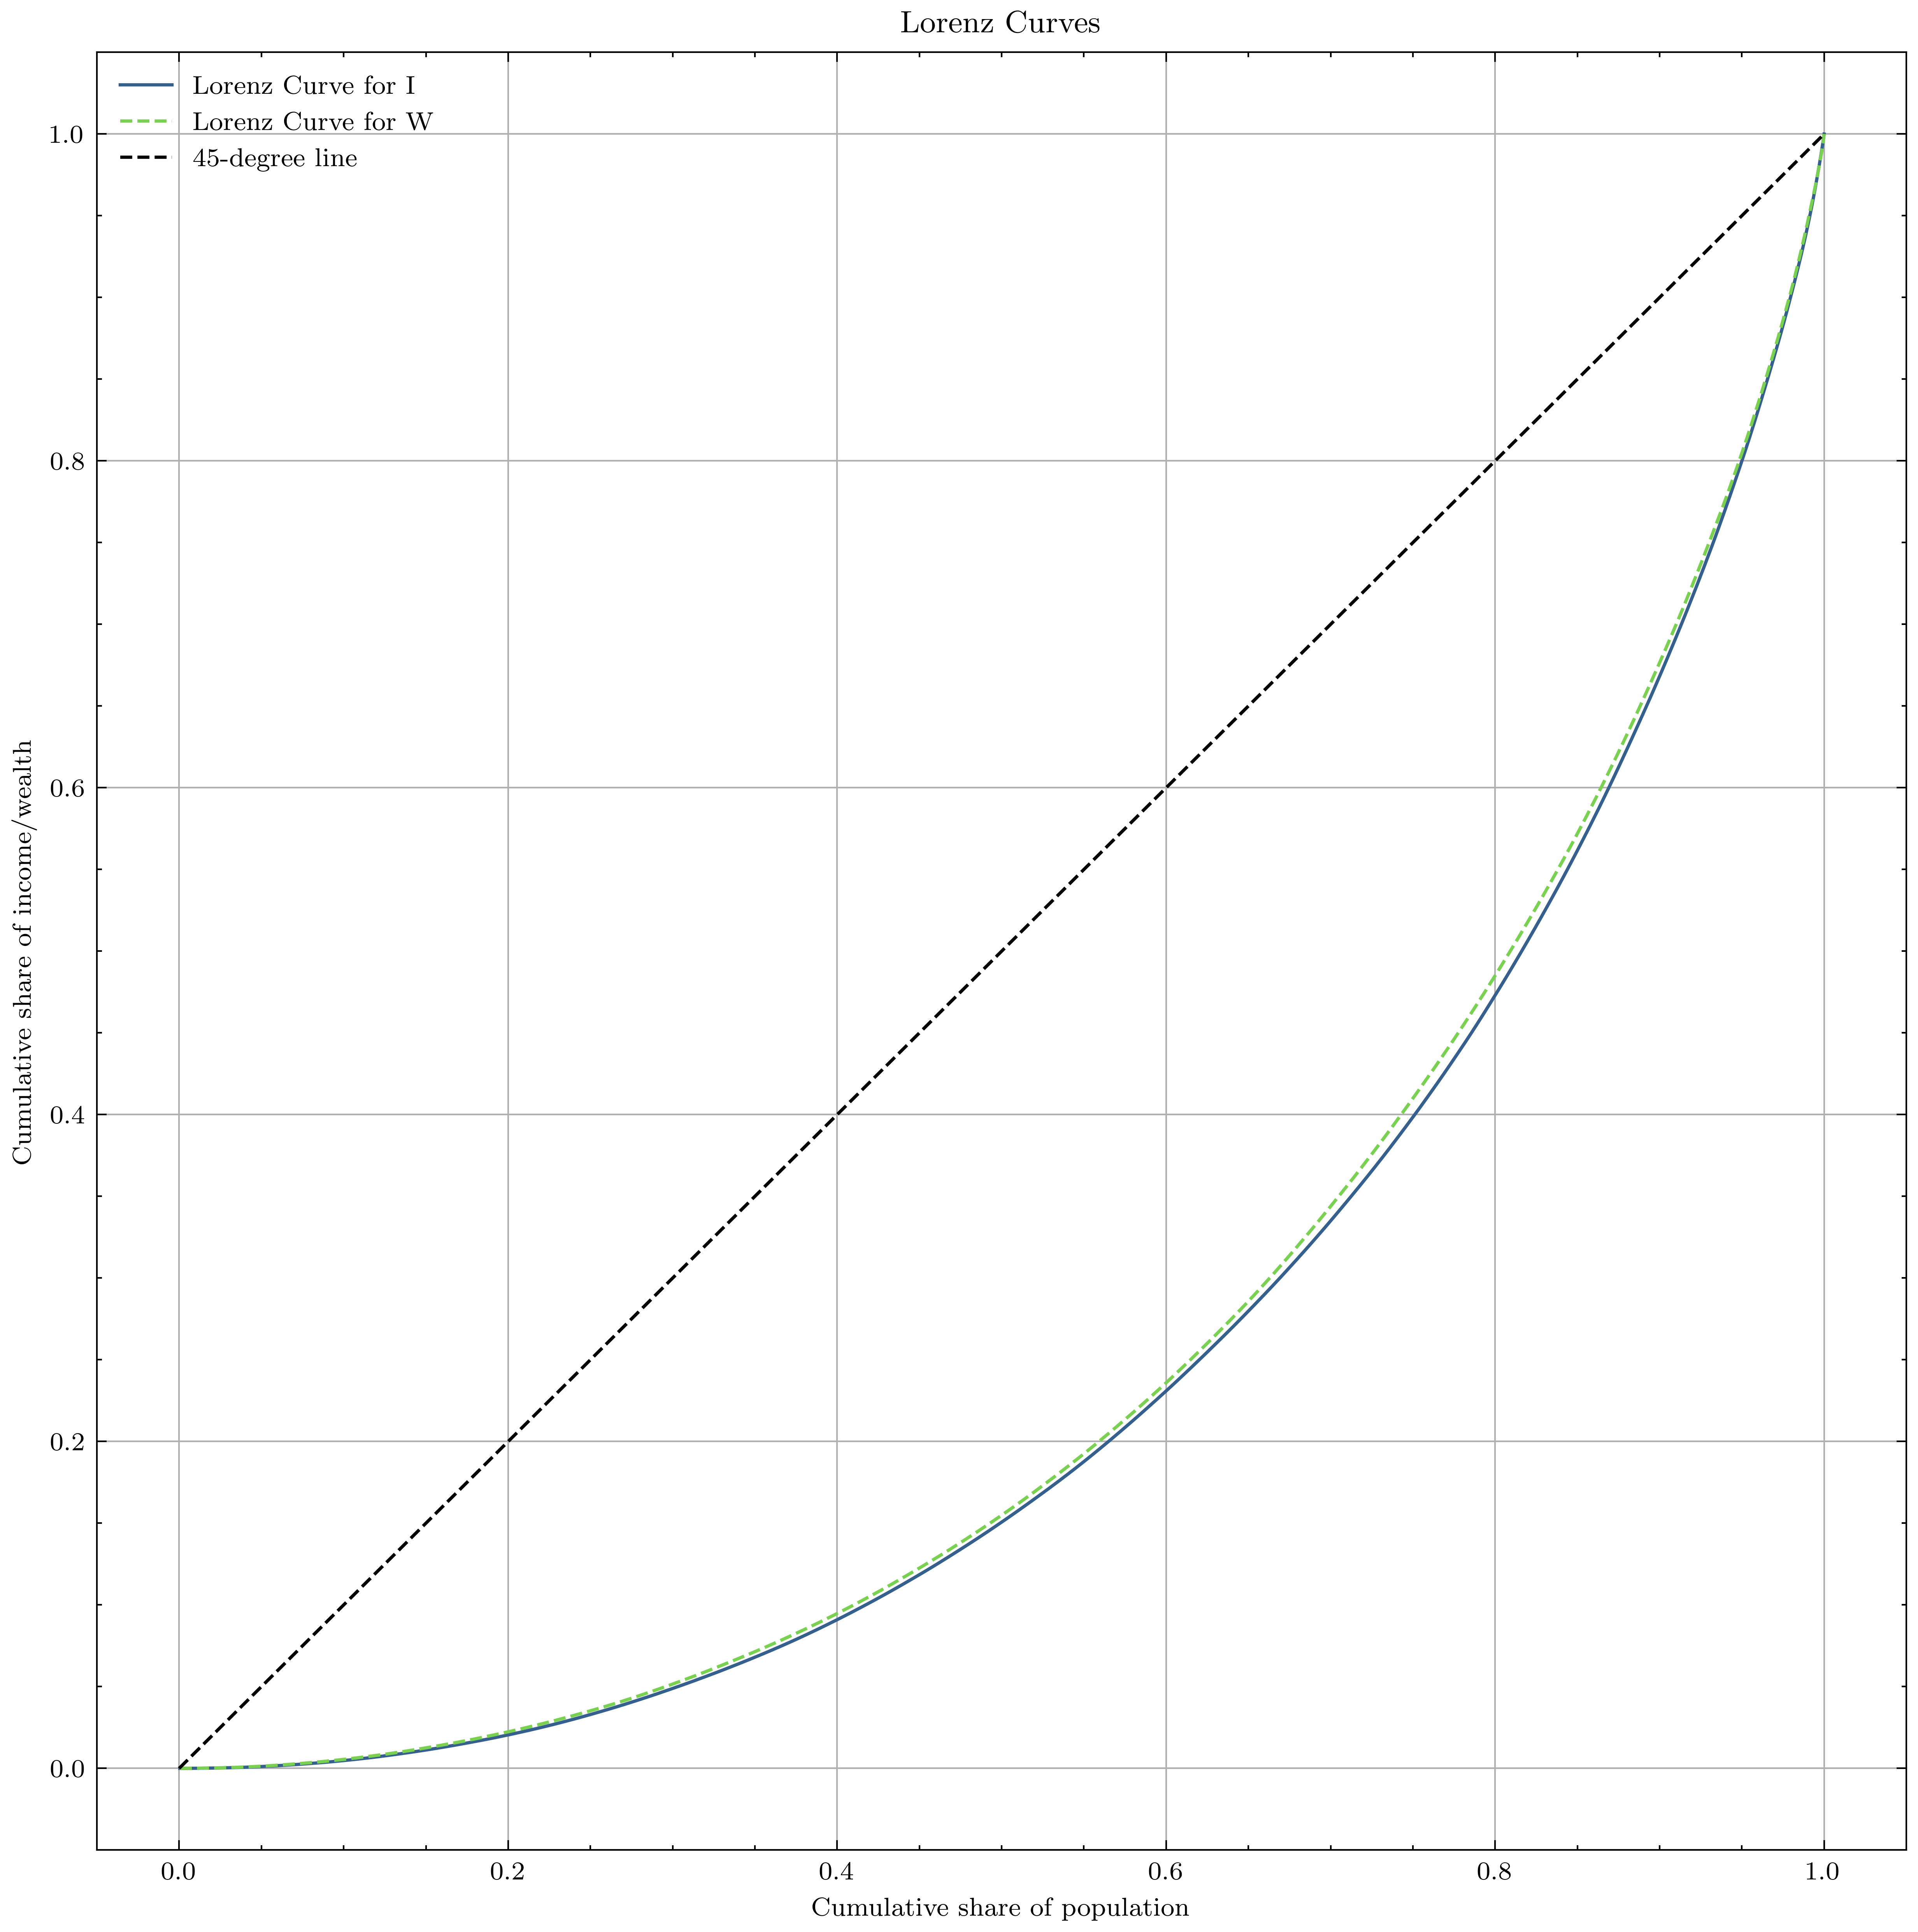

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to compute the Lorenz curve
def lorenz_curve(data):
    n = len(data)
    x = np.arange(1, n+1) / n
    y = np.cumsum(np.sort(data)) / np.sum(data)
    return x, y

custom_cmap = get_cmap('viridis')

# Generate some sample data for illustration
# You should replace these with `I_sorted` and `W_sorted` from your data
I_sorted = np.sort(np.random.exponential(scale=50, size=2500))
W_sorted = np.sort(np.random.exponential(scale=100, size=2500))

# Calculate Lorenz curves
x_I, y_I = lorenz_curve(I_sorted)
x_W, y_W = lorenz_curve(W_sorted)

# Plotting
plt.figure(figsize=(10, 10))

# Plot Lorenz curves
plt.plot(x_I, y_I, label="Lorenz Curve for I", color=custom_cmap(0.3))
plt.plot(x_W, y_W, label="Lorenz Curve for W", color=custom_cmap(0.8))

# Plot 45-degree line
plt.plot([0, 1], [0, 1], 'k--', label="45-degree line")

plt.xlabel("Cumulative share of population")
plt.ylabel("Cumulative share of income/wealth")
plt.title("Lorenz Curves")
plt.legend()
plt.grid(True)

plt.show()

## SF 2 GDP growth distribution

In [69]:
#SF 12, 5
def filepath(i):
    return f'15 Data/{i}_model.csv'

# n_MC = 100
n_MC = 9

df_list = []

for MC_i in range(1235, n_MC + 1235):
    #df_list.append(pd.read_csv(filepath(MC_i)).iloc[550:650])
    df_list.append(pd.read_csv(filepath(MC_i)).iloc[300:])
    #FIXME adjust sampling window
df = pd.concat(df_list)

#no limits to head() number of colums
pd.set_option('display.max_columns', None)
df.head()

,CPI_cp,CPI_kp,D_ep,EI_avg,Exp_UB,GDP,GDP_cp,GDP_growth,GDP_hh,GDP_kp,GINI_I,GINI_W,IN_d,IN_g,I_20,I_80,I_max,I_min,LIS,M,M_cp,M_ep,M_gov,M_hh,M_if,M_kp,N_goods,Qmax_ep,RD_ep,RD_total,RS_avg,U,W_20,W_80,W_max,W_min,YK_avg,YL_avg,YSB_avg,YUB_avg,Y_avg,avg_A_EE,avg_A_EF,avg_A_LP,avg_B_EE,avg_B_EF,avg_B_LP,avg_D_cp,avg_De_cp,avg_Du_cp,avg_N_goods,avg_Q_cp,avg_Q_kp,avg_Qe_cp,avg_Qs_cp,avg_n_machines_cp,avg_pi_EE,avg_pi_EF,avg_pi_LP,bankrupt_cp,bankrupt_kp,cu,dL_avg,dL_cp_avg,dL_kp_avg,debt_cp,debt_cp_allowed,debt_kp,debt_kp_allowed,debt_tot,debt_unpaid_cp,debt_unpaid_kp,dirty_capacity,em_index,em_index_cp,em_index_ep,em_index_kp,energy_percentage,exp_UB,exp_subsidies,green_capacity,markup_cp,markup_kp,n_mach_EI_avg,n_mach_RS_avg,p_avg_cp,p_avg_kp,p_ep,percentile_100,percentile_25,percentile_50,percentile_75,returns_investments,rev_capitaltax,rev_carbontax,rev_energytax,rev_incometax,rev_profittax,rev_salestax,s_emp,s_unemp,switch_rate,total_C,total_C_actual,total_I,total_Q_cp,total_Q_growth,total_Q_kp,total_w,unsat_L_demand,unsat_demand,unsat_invest,unspend_C,w_avg,w_req_avg,w_sat_avg,τˢ_ts,τᴱ_ts,τᴵ_ts,τᴷ_ts,τᴾ_ts,τᶜ_ts
300,113.058943,96.678294,342635.577511,0.0,0.0,648148.524974,102650.193765,-0.467424,539324.511285,6173.819924,0.176513,0.341967,603.257963,402.171975,154.906202,278.127677,454.217920,110.519946,0.528405,889391.250063,127088.987945,9.569072,191546.586649,457956.793715,110810.809211,1978.503471,40905.991044,424466.886383,1005.429938,1404.782427,0.0,0.0880,78.123012,277.258359,576.019534,8.600864e-02,34.384369,102.745490,75.519946,3.080,215.729805,1.118929,0.918653,1.318199,1.048635,0.928918,1.098396,1837.394118,1986.993398,192.997922,204.529955,1839.355864,585.00,2364.774583,2158.406087,2584.875,1.109672,0.924167,1.280231,0.0,0.05,0.701855,76.805800,67.148077,173.383031,26267.333843,1.077162e+06,418.644800,28457.453783,26685.978642,0.0,270.363582,370000.0,102.530964,99.653490,104.158368,194.984336,0.540801,7700.0,188799.864756,0.0,0.100610,0.168975,0.485,4.390,1.465611,1.276317,0.296235,343.828227,61.780528,123.223518,203.898597,0.188011,28653.640898,57272.395974,0.0,85621.241279,27352.682611,0.0,0.339986,0.409689,0.042620,539004.592275,538581.028579,14228.726891,367871.172838,0.008017,11700.0,342484.965115,0.192072,0.095055,0.520000,0.000786,1.494168,1.504264,1.464036,0.0,0.0,0.25,0.25,0.25,0.101143
301,113.247283,83.260663,339199.425725,0.0,0.0,640316.198871,98289.513068,-2.052511,539609.075223,2417.610580,0.175709,0.339883,609.004660,406.003107,154.772948,278.466374,483.558990,111.634212,0.536830,890667.280081,124149.735548,9.569072,189457.978334,461618.374383,113551.743451,1879.879293,43149.183699,424466.886383,1015.007767,1718.715538,0.0,0.0848,79.414118,278.743179,586.092766,1.832038e-02,33.134782,103.122213,76.618635,2.968,215.843630,1.119465,0.917765,1.320185,1.049484,0.928276,1.098777,1825.368899,1995.673126,173.241928,215.745918,1836.584862,437.50,2375.586523,2161.351333,2592.125,1.109726,0.924131,1.281692,0.0,0.10,0.708054,65.433285,66.907973,50.686401,26266.989939,1.071895e+06,288.733105,18704.339825,26555.723043,0.0,155.689767,370000.0,100.131073,99.451763,100.000000,145.054270,0.552642,7420.0,191546.586649,0.0,0.100655,0.166228,0.795,2.545,1.468053,1.099182,0.297323,345.542669,63.045683,124.595103,205.405944,0.180884,27612.318493,56563.847959,0.0,85935.177699,25725.311778,0.0,0.344392,0.415550,0.042039,536141.389230,535947.494555,9352.169912,367316.972388,0.008235,8750.0,343740.710795,0.172914,0.086681,0.476048,0.000362,1.501653,1.503411,1.463014,0.0,0.0,0.25,0.25,0.25,0.102286
302,110.931499,96.679802,340758.505371,0.0,0.0,650821.650925,106247.170844,2.669637,540708.353993,3866.126087,0.176116,0.342818,605.110980,403.407320,155.039260,278.800191,490.761723,110.786566,0.531194,889928.055413,125104.975094,9.542774,193458.616335,454561.304469,115758.889749,1034.726993,31732.945923,424466.886383,1008.518300,1462.963763,0.0,0.0804,78.038942,275.435518,590.302923,-4.263256e-14,33.972305,103.713846,75.783191

/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_81552/384742941.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(bins, dens, s=10, c=custom_cmap(0.2), label='growth rates')


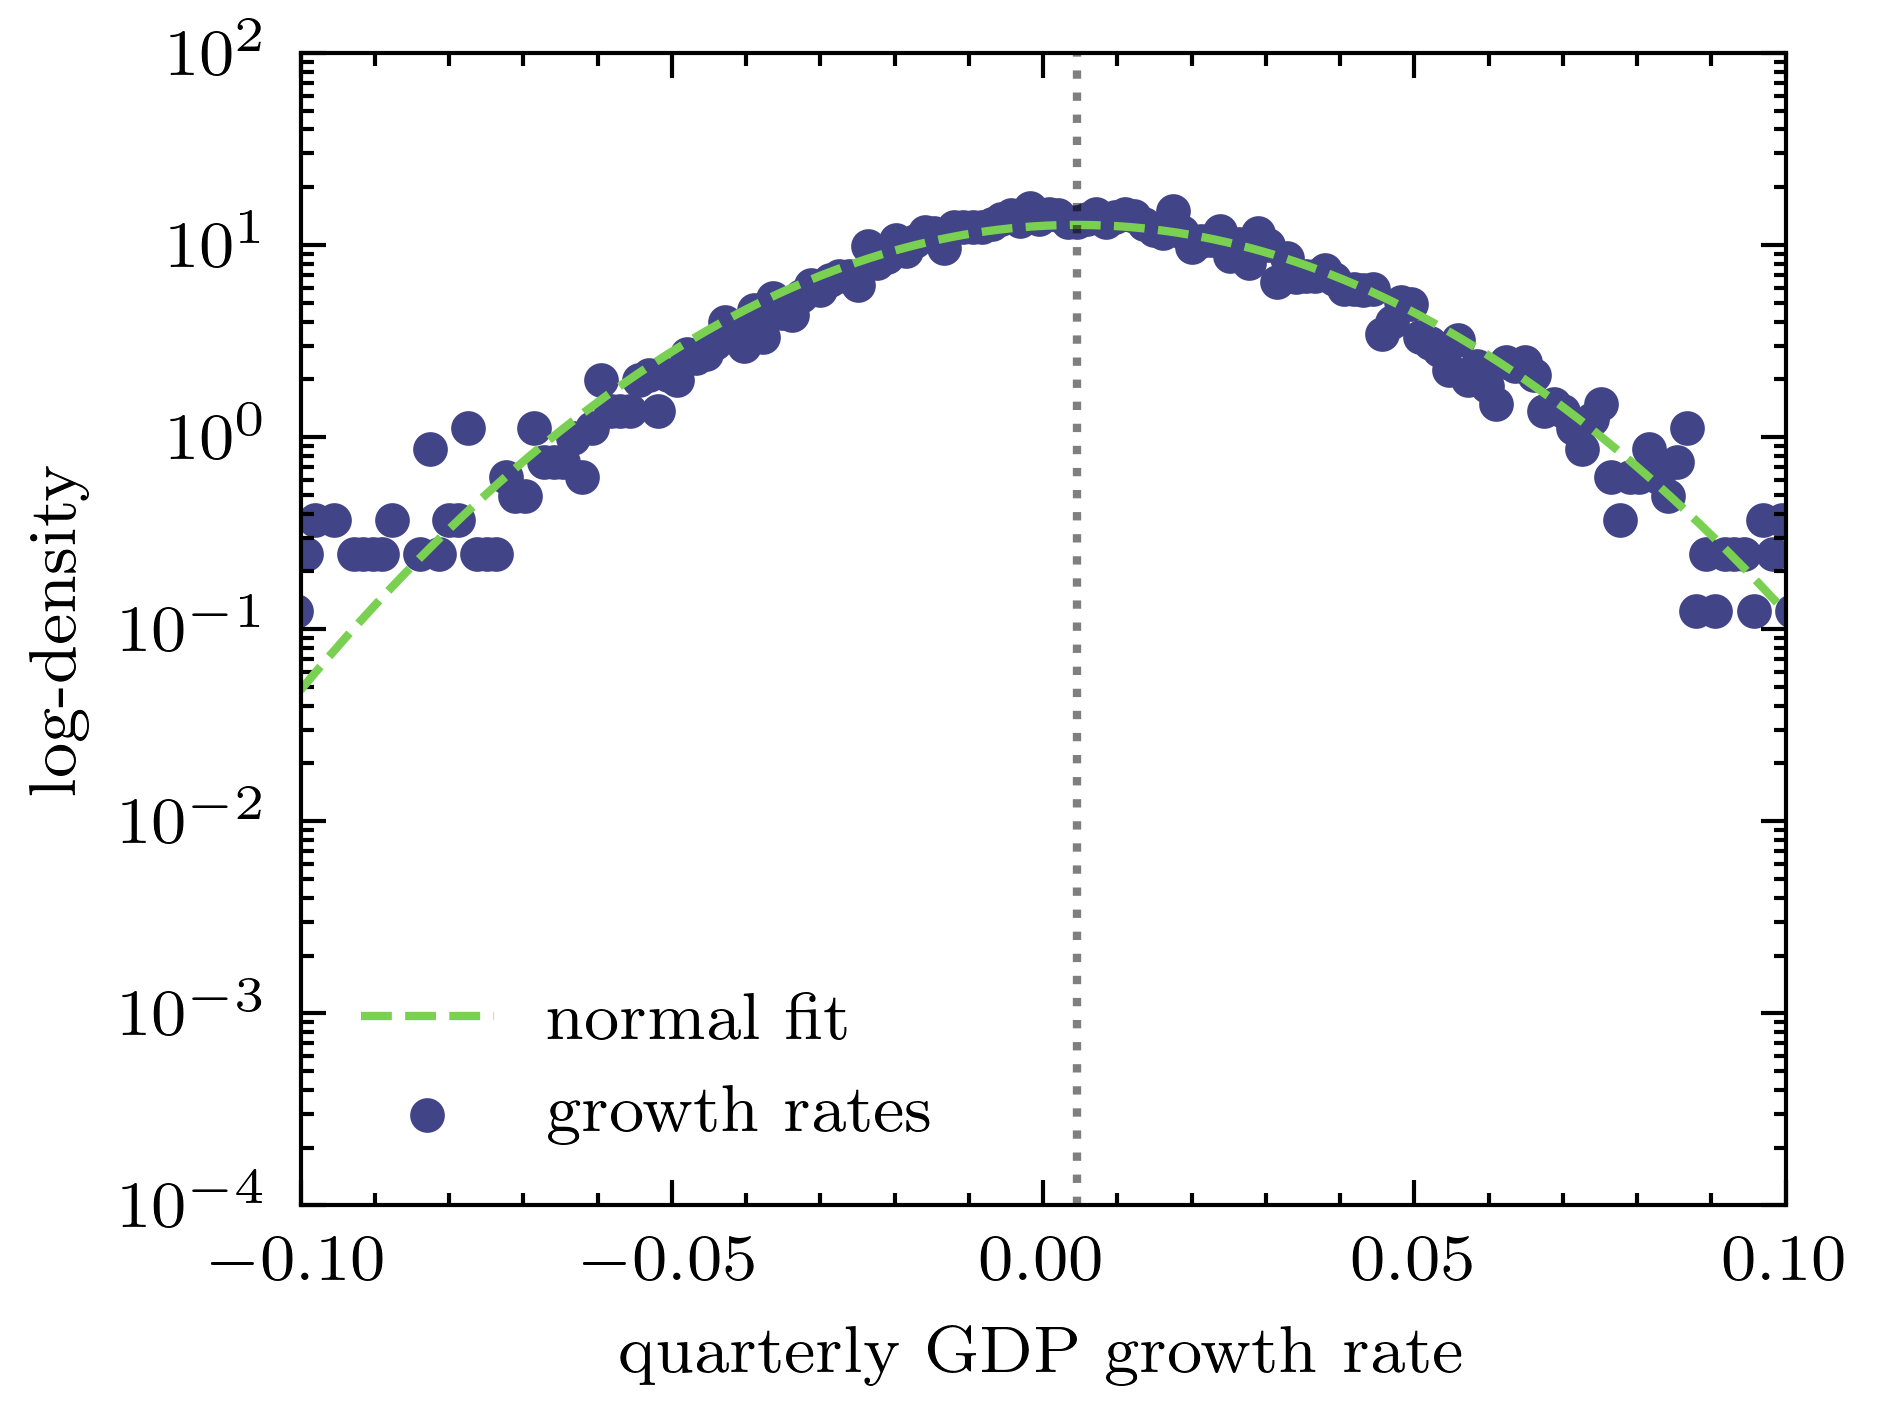

In [68]:
#plot distribution of GDP growth rates

data = df.GDP_growth / 100
mean_GDP_growth = np.mean(data)
x = np.linspace(-0.1, 0.1, 1000)
dens, bins, _ = plt.hist(data, bins=250, density=True, alpha=0.)
mu, sigma = stats.norm.fit(data)
best_fit_line = stats.norm.pdf(x, mu, sigma)
bins1 = bins[:-1]
bins2 = bins[1:]



bins = np.mean([bins1, bins2], axis=0)


plt.style.use(['science','ieee'])
plt.tight_layout()



plt.plot(x, best_fit_line, color=custom_cmap(0.8), label='normal fit')
plt.scatter(bins, dens, s=10, c=custom_cmap(0.2), label='growth rates')
plt.legend(loc='lower left')
plt.xlabel('quarterly GDP growth rate')
plt.ylabel('log-density')
plt.xlim(-0.1, 0.1)
plt.ylim(10e-5, 100)
plt.axvline(mean_GDP_growth, linestyle='dotted', alpha=0.5, c='black')

plt.yscale('log')
plt.tight_layout()
#plt.savefig('../../plotting/validation/gr_dist.pdf', bbox_inches='tight')
plt.show()

## SF3 The duration of recessions is exponentially distributed.

(Partial) reproduction of Dosi (2017) fig 3

In [70]:
# Count recession periods
durations = []


for g in df.GDP_growth:

    if g < 0:
        if recession:
            duration += 1
        else:
            recession = True
            duration = 1
        
    elif g > 0 and recession:
        recession = False
        durations += [duration]

durations = np.array(durations)



loc, scale = stats.expon.fit(durations)

counts = {}
for d in durations:
    if d not in counts:
        counts[d] = 1
    else:
        counts[d] += 1

totcount = sum(counts.values())

for c in counts:
    counts[c] /= totcount



<Figure size 1980x1500 with 0 Axes>

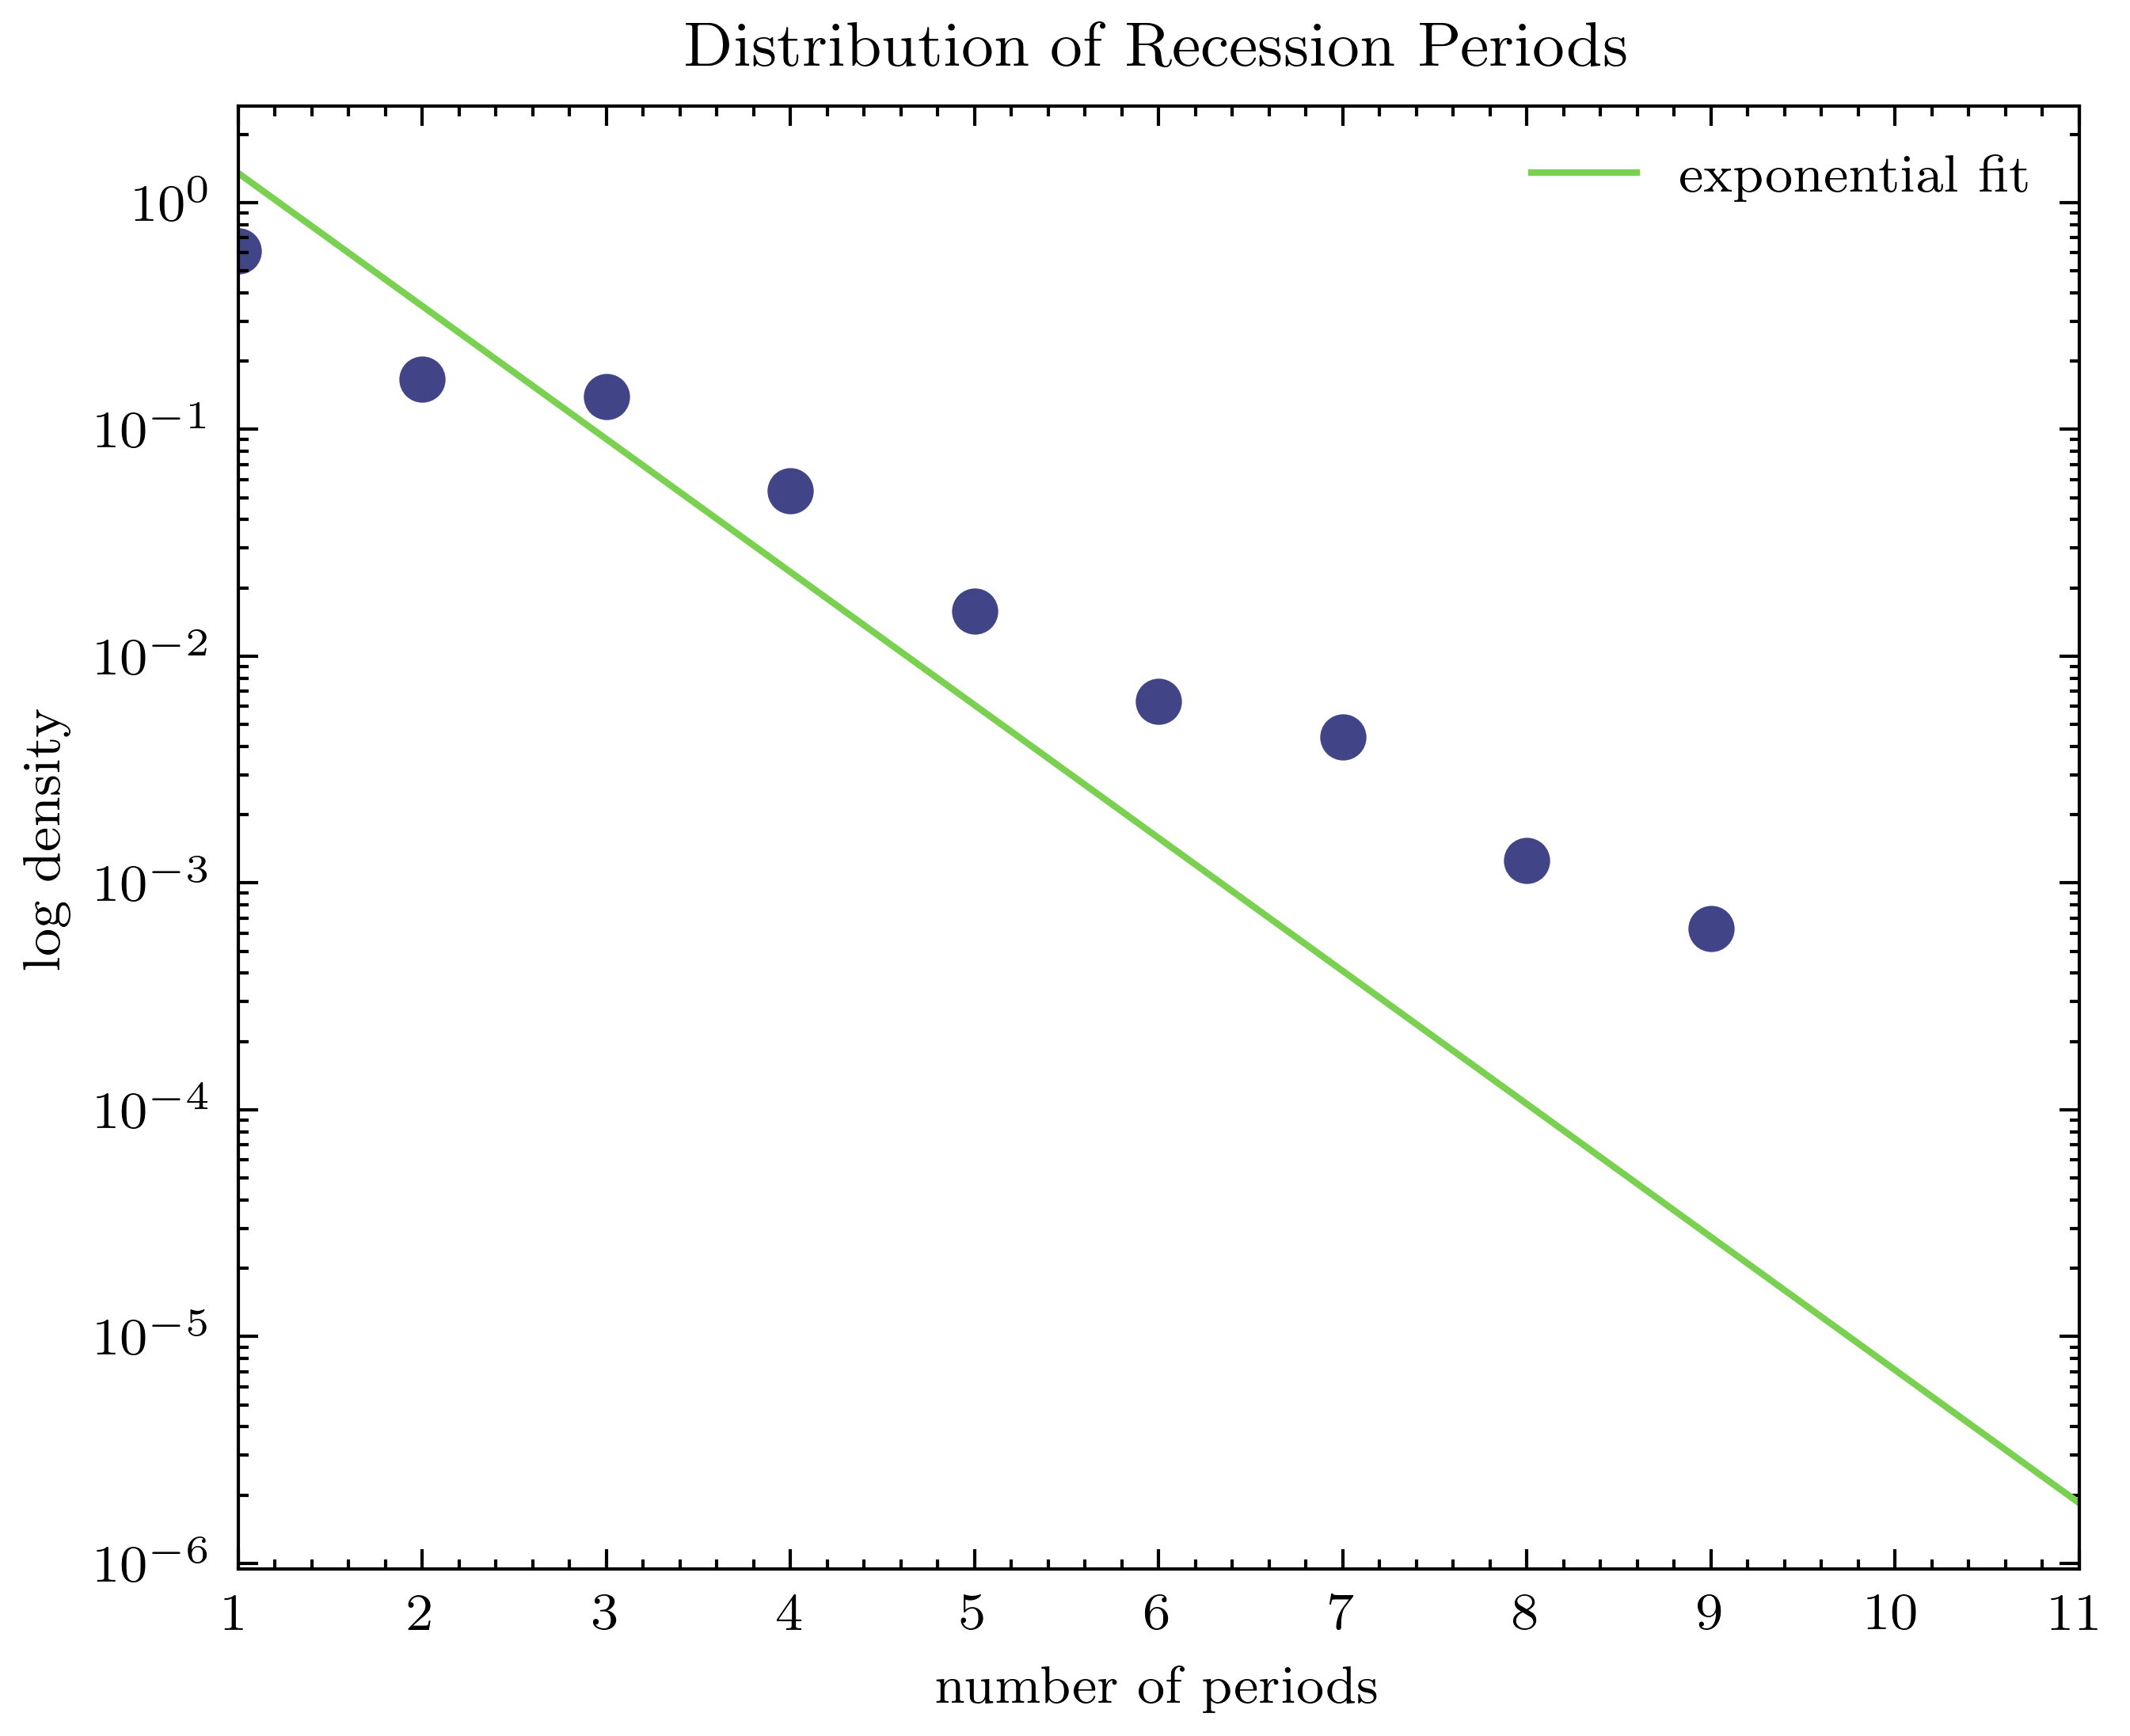

In [72]:
#plot for recession periods


plt.style.use(['science','ieee'])
plt.tight_layout()


plt.figure(figsize=(5,4))

x = np.linspace(1, 11, 100)

plt.plot(x, stats.expon.pdf(x, loc, scale), label='exponential fit', c=custom_cmap(0.8))
plt.scatter(counts.keys(), counts.values(), color=custom_cmap(0.2))
# plt.scatter(np.linspace(1, max(bins), len(dens)), dens, label='simulated data', c='red', s=30, zorder=2)
plt.xlim(1, 11)
plt.xticks(range(1, 12))
plt.yscale('log')
plt.title('Distribution of Recession Periods')
plt.xlabel('number of periods')
plt.ylabel('log density')
plt.legend()

#plt.savefig('../../plotting/validation/rec_fit.pdf', bbox_inches='tight')
plt.show()

## SF related to Firms

### SF 7,8
Firms investment lumpiness.



In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats



#load kp_firm data from Firm folder into df_new
df_new1 = pd.read_csv('Firm_3/1234_kp_firm2.csv')
df_new2 = pd.read_csv('Firm_3/1234_cp_firm2.csv')

#filter out firm sizes below 


#sort by timestep
df_new1 = df_new1.sort_values(by=['timestamp'])
df_new2 = df_new2.sort_values(by=['timestamp'])

# Extract the 'size' column and convert it to a numpy array
size_month = df_new1['size'].to_numpy()
size_month2 = df_new2['size'].to_numpy()

# Assuming monthly data and pooling it to make it yearly (example uses 3 months to 1 year, which may not be accurate here)
# Here, I'm using 12 months to make it yearly. Adjust this as needed based on your actual data frequency.
size_year = np.array([np.sum(size_month[i:i+12]) for i in np.arange(0, len(size_month), step=12)])
size_year2 = np.array([np.sum(size_month2[i:i+12]) for i in np.arange(0, len(size_month2), step=12)])

#join both arrays
all_size_year = np.concatenate((size_year, size_year2), axis=None)
#compare shape of both arrays
#print(size_year.shape, size_year2.shape, all_size_year.shape)


# Calculate the yearly mean
size_year_mean = np.mean(size_year)
size_year_mean2 = np.mean(size_year2)
all_year_mean = np.mean(all_size_year)

#print(size_year_mean, size_year_mean2)

# Normalize and sort the data
size_year_norm = size_year / size_year_mean
size_year_norm = np.sort(size_year_norm)[::-1]
size_year_norm2 = size_year2 / size_year_mean2
size_year_norm2 = np.sort(size_year_norm2)[::-1]
all_year_norm = all_size_year / all_year_mean
all_year_norm = np.sort(all_year_norm)[::-1]

#for all values add 1
shift=0.5
size_year_norm = size_year_norm + shift
size_year_norm2 = size_year_norm2 + shift
all_year_norm = all_year_norm + shift






#turn all three in df and show head
df_size_year_norm = pd.DataFrame(size_year_norm)
df_size_year_norm2 = pd.DataFrame(size_year_norm2)
df_all_year_norm = pd.DataFrame(all_year_norm)

#sort each by size starting with lowest and show head
df_size_year_norm = df_size_year_norm.sort_values(by=[0])
df_size_year_norm2 = df_size_year_norm2.sort_values(by=[0])
df_all_year_norm = df_all_year_norm.sort_values(by=[0])

df_size_year_norm.head()


# Perform statistical tests
firmsizetable = {}

jb_val, p_val = stats.jarque_bera(np.log(size_year_norm))
firmsizetable['Jarque-Bera'] = [jb_val, round(p_val, 2)]

stat, p_val = stats.shapiro(np.log(size_year_norm))
firmsizetable['Shapiro-Wilkes'] = [stat, round(p_val, 2)]

stat, crit, p_val = stats.anderson(np.log(size_year_norm), dist='norm')
firmsizetable['Anderson-Darling'] = [stat, 0.0]

# Create and display a DataFrame for the test statistics
df_firmtable = pd.DataFrame(firmsizetable, index=['test stat', 'p-val']).round(2)
df_firmtable.head(), df_firmtable.to_latex()


(           Jarque-Bera  Shapiro-Wilkes  Anderson-Darling
 test stat      5376.31            0.86             24.77
 p-val             0.00            0.00              0.00,
 '\\begin{tabular}{lrrr}\n\\toprule\n & Jarque-Bera & Shapiro-Wilkes & Anderson-Darling \\\\\n\\midrule\ntest stat & 5376.310000 & 0.860000 & 24.770000 \\\\\np-val & 0.000000 & 0.000000 & 0.000000 \\\\\n\\bottomrule\n\\end{tabular}\n')

/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_96944/1361763975.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = get_cmap('viridis')


<Figure size 1980x1500 with 0 Axes>

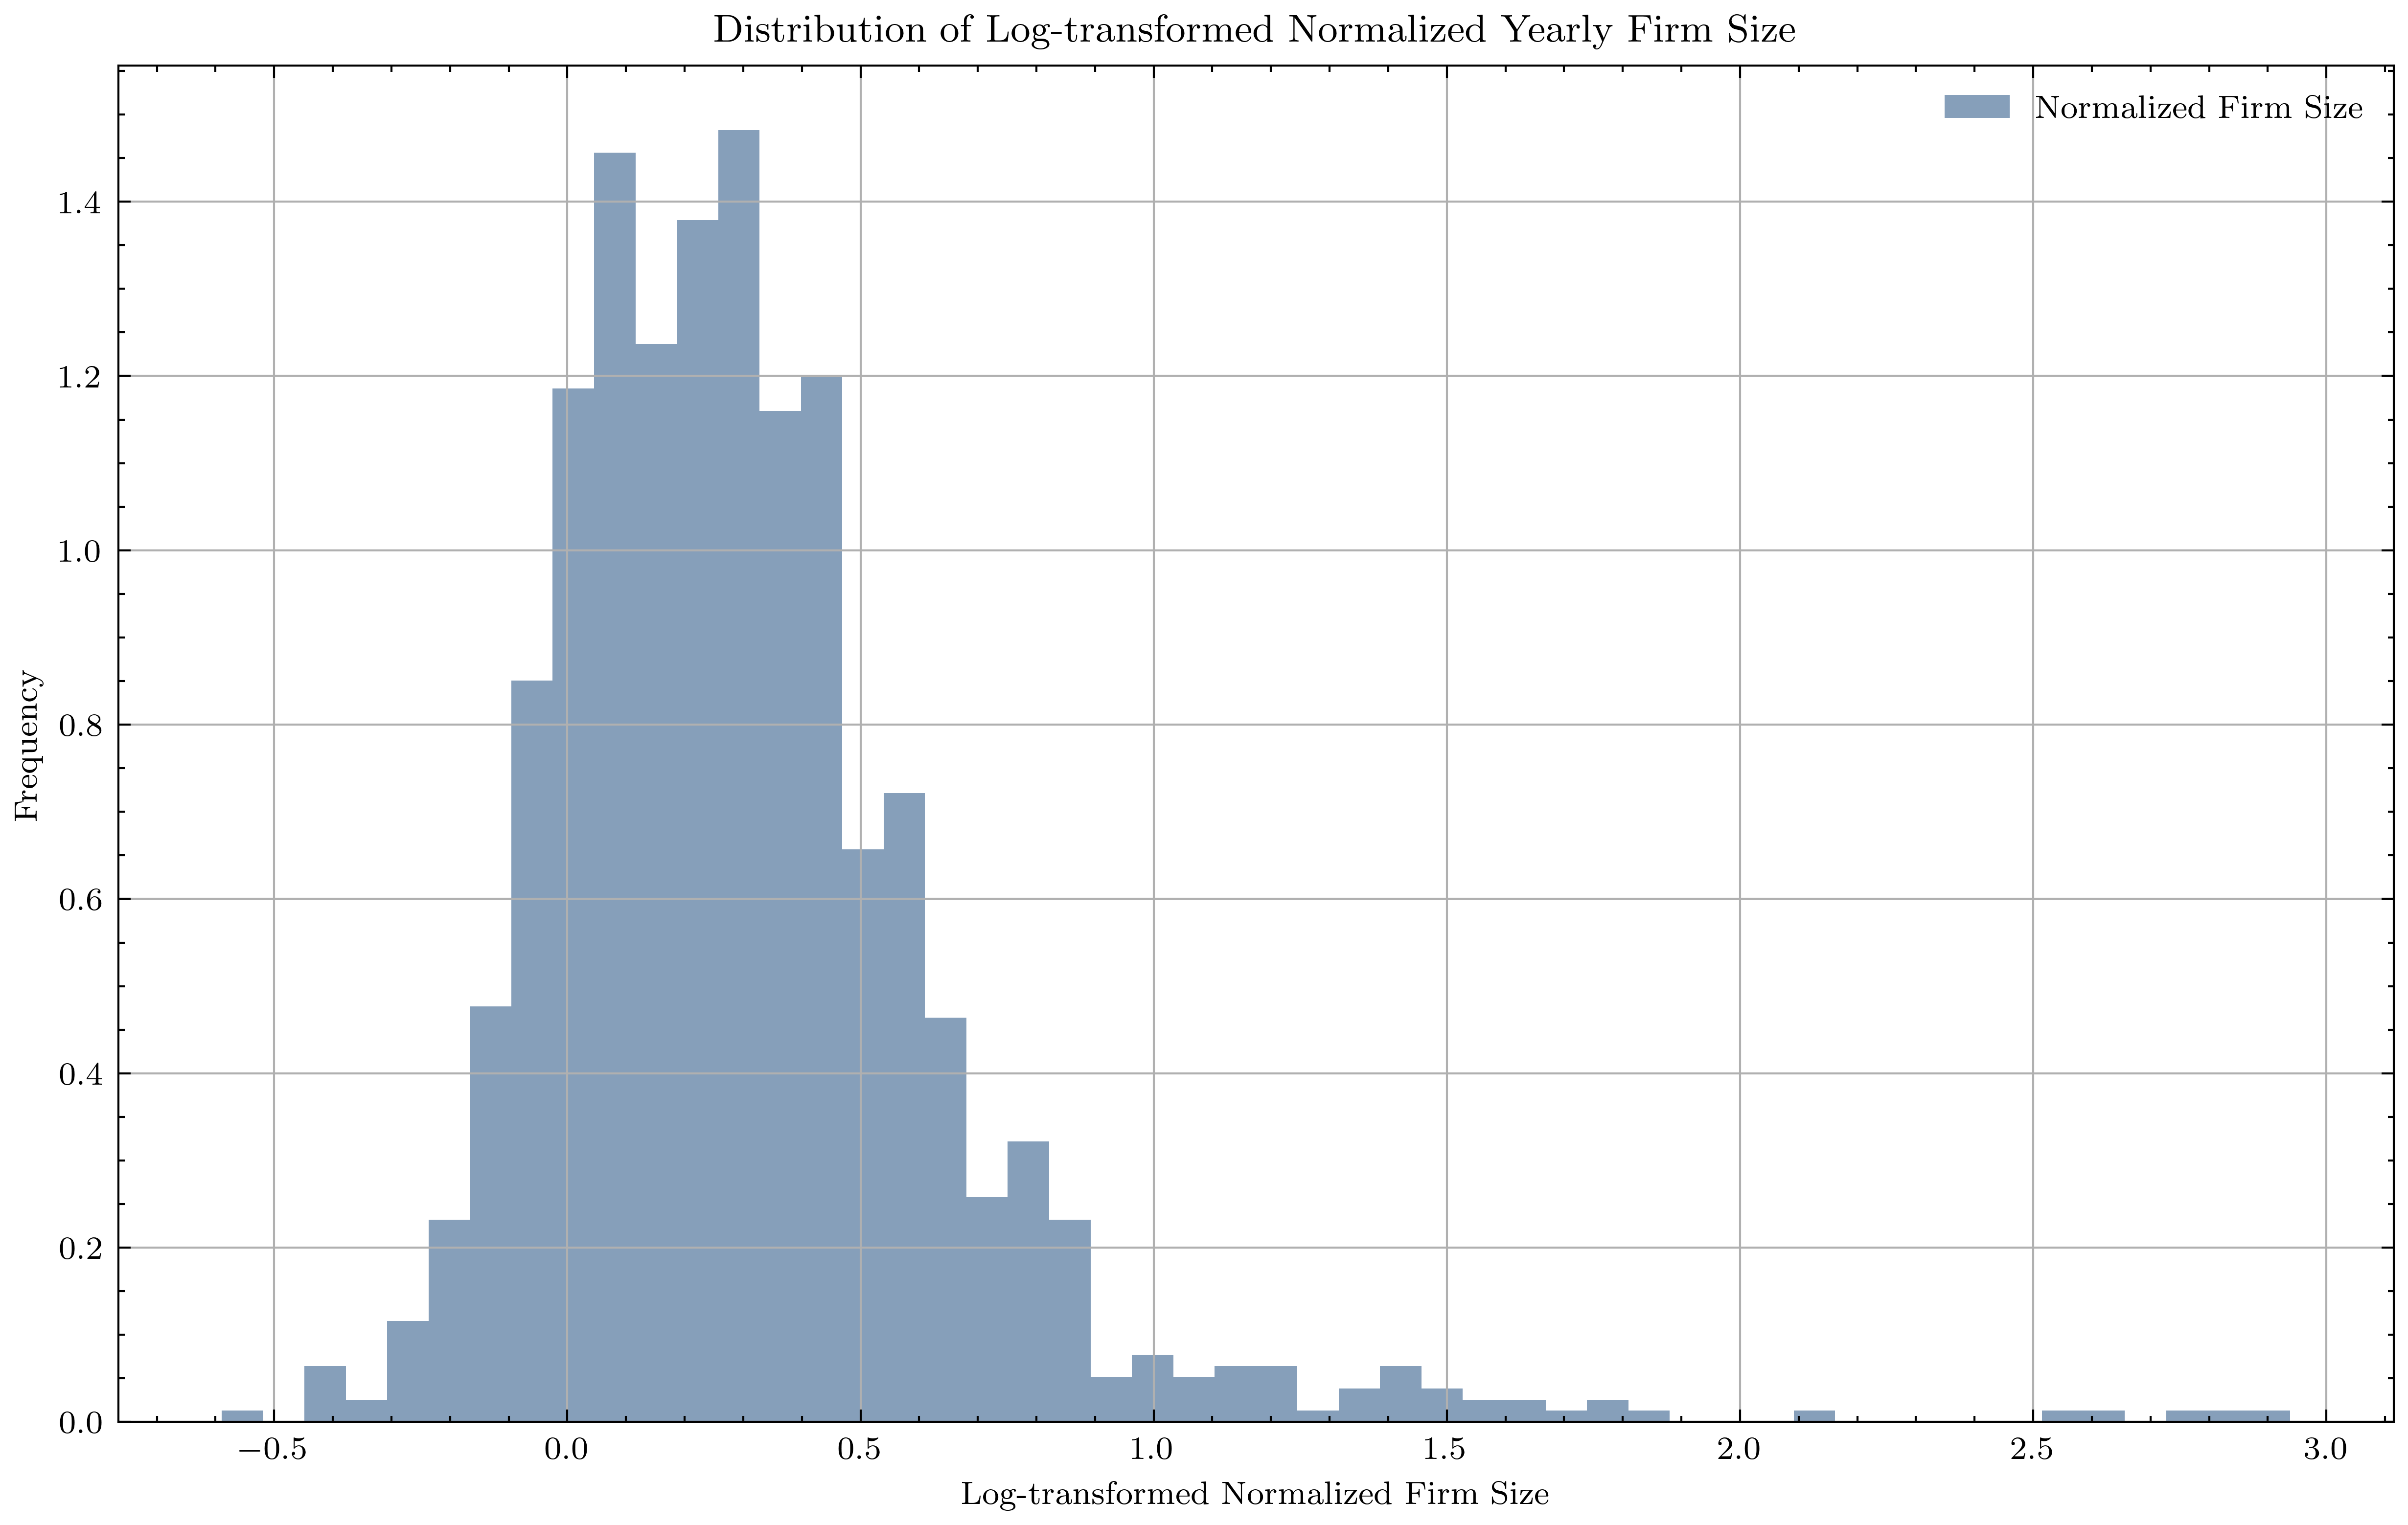

In [98]:
import matplotlib.pyplot as plt

# Log-transform the normalized employee data for plotting
log_size_year_norm = np.log(size_year_norm)

#use science style
plt.style.use(['science','ieee'])
plt.tight_layout()
#use viridis package for colors
custom_cmap = get_cmap('viridis')

# Generate the plot
plt.figure(figsize=(10, 6))
plt.hist(log_size_year_norm, bins=50, density=True, alpha=0.6, color=custom_cmap(0.3), label='Normalized Firm Size')
plt.title('Distribution of Log-transformed Normalized Yearly Firm Size')
plt.xlabel('Log-transformed Normalized Firm Size')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
# Load the new cp_firm data
df_model1 = pd.read_csv('Firm_2/2352_model.csv')
df_cp_firm = pd.read_csv('Firm_3/size_year_norm.csv')

GDP = df_model1['GDP'].to_numpy()
GDP_growth = np.diff(GDP)
GDP_growth_mean = np.mean(GDP_growth)
GDP_growth_norm = np.log(GDP_growth / GDP_growth_mean)


# Filter out problematic entries before log transformation
GDP_growth_filtered = GDP_growth[GDP_growth > 0]
GDP_growth_norm_filtered = np.log(GDP_growth_filtered / np.mean(GDP_growth_filtered))


skew_stat_GDP, skew_p_val_GDP = stats.skewtest(GDP_growth_norm_filtered)
kurt_stat_GDP, kurt_p_val_GDP = stats.kurtosistest(GDP_growth_norm_filtered)


# Calculate firm size growth in the new cp_firm data
cp_size = df_cp_firm['0'].to_numpy()
cp_size_growth = np.diff(cp_size)
cp_size_growth_filtered = cp_size_growth[cp_size_growth > 0]
cp_size_growth_norm_filtered = np.log(cp_size_growth_filtered / np.mean(cp_size_growth_filtered))

# Calculate simple firm size in the new cp_firm data (already in 'cp_size' variable)
# Normalize and filter
cp_size_filtered = cp_size[cp_size > 0]
cp_size_norm_filtered = np.log(cp_size_filtered / np.mean(cp_size_filtered))

# Perform skewness and kurtosis tests on these variables in the new cp_firm data
skew_stat_cp_size_growth, skew_p_val_cp_size_growth = stats.skewtest(cp_size_growth_norm_filtered)
kurt_stat_cp_size_growth, kurt_p_val_cp_size_growth = stats.kurtosistest(cp_size_growth_norm_filtered)

skew_stat_cp_size, skew_p_val_cp_size = stats.skewtest(cp_size_norm_filtered)
kurt_stat_cp_size, kurt_p_val_cp_size = stats.kurtosistest(cp_size_norm_filtered)

# Update the table to include these new variables from cp_firm
skew_kurt_table_cp_firm = {
    'GDP_growth': [skew_stat_GDP, skew_p_val_GDP, kurt_stat_GDP, kurt_p_val_GDP],
    'cp_size_growth': [skew_stat_cp_size_growth, skew_p_val_cp_size_growth, kurt_stat_cp_size_growth, kurt_p_val_cp_size_growth],
    'cp_size': [skew_stat_cp_size, skew_p_val_cp_size, kurt_stat_cp_size, kurt_p_val_cp_size]
}

df_skew_kurt_cp_firm = pd.DataFrame(skew_kurt_table_cp_firm, index=['skew test stat', 'skew p-val', 'kurt test stat', 'kurt p-val']).round(2)
df_skew_kurt_cp_firm, df_skew_kurt_cp_firm.to_latex()



/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_96944/1853576487.py:8: RuntimeWarning: invalid value encountered in log
  GDP_growth_norm = np.log(GDP_growth / GDP_growth_mean)


(                GDP_growth  cp_size_growth  cp_size
 skew test stat       -6.11            8.24    19.18
 skew p-val            0.00            0.00     0.00
 kurt test stat        3.94            8.70    14.23
 kurt p-val            0.00            0.00     0.00,
 '\\begin{tabular}{lrrr}\n\\toprule\n & GDP_growth & cp_size_growth & cp_size \\\\\n\\midrule\nskew test stat & -6.110000 & 8.240000 & 19.180000 \\\\\nskew p-val & 0.000000 & 0.000000 & 0.000000 \\\\\nkurt test stat & 3.940000 & 8.700000 & 14.230000 \\\\\nkurt p-val & 0.000000 & 0.000000 & 0.000000 \\\\\n\\bottomrule\n\\end{tabular}\n')

## SF 9,10

In [80]:
import os


# Specify the folder where the CSV files are located
folder_path = "Firm_1"  # Replace with your actual folder path

# List all files in the specified folder
all_files = os.listdir(folder_path)

# Filter out files whose names contain 'kp_firm' and end with '.csv'
kp_firm_files = [f for f in all_files if 'kp_firm' in f and f.endswith('.csv')]

# Read these files into a list of DataFrames
dfs_filtered = [pd.read_csv(os.path.join(folder_path, f)) for f in kp_firm_files]

# Concatenate the filtered DataFrames along rows
df_concatenated1 = pd.concat(dfs_filtered, ignore_index=True)

#save aggregated data to csv
df_concatenated1.to_csv('kp_firm_aggregated.csv', index=False)






/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_49447/1150646009.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = get_cmap('viridis')


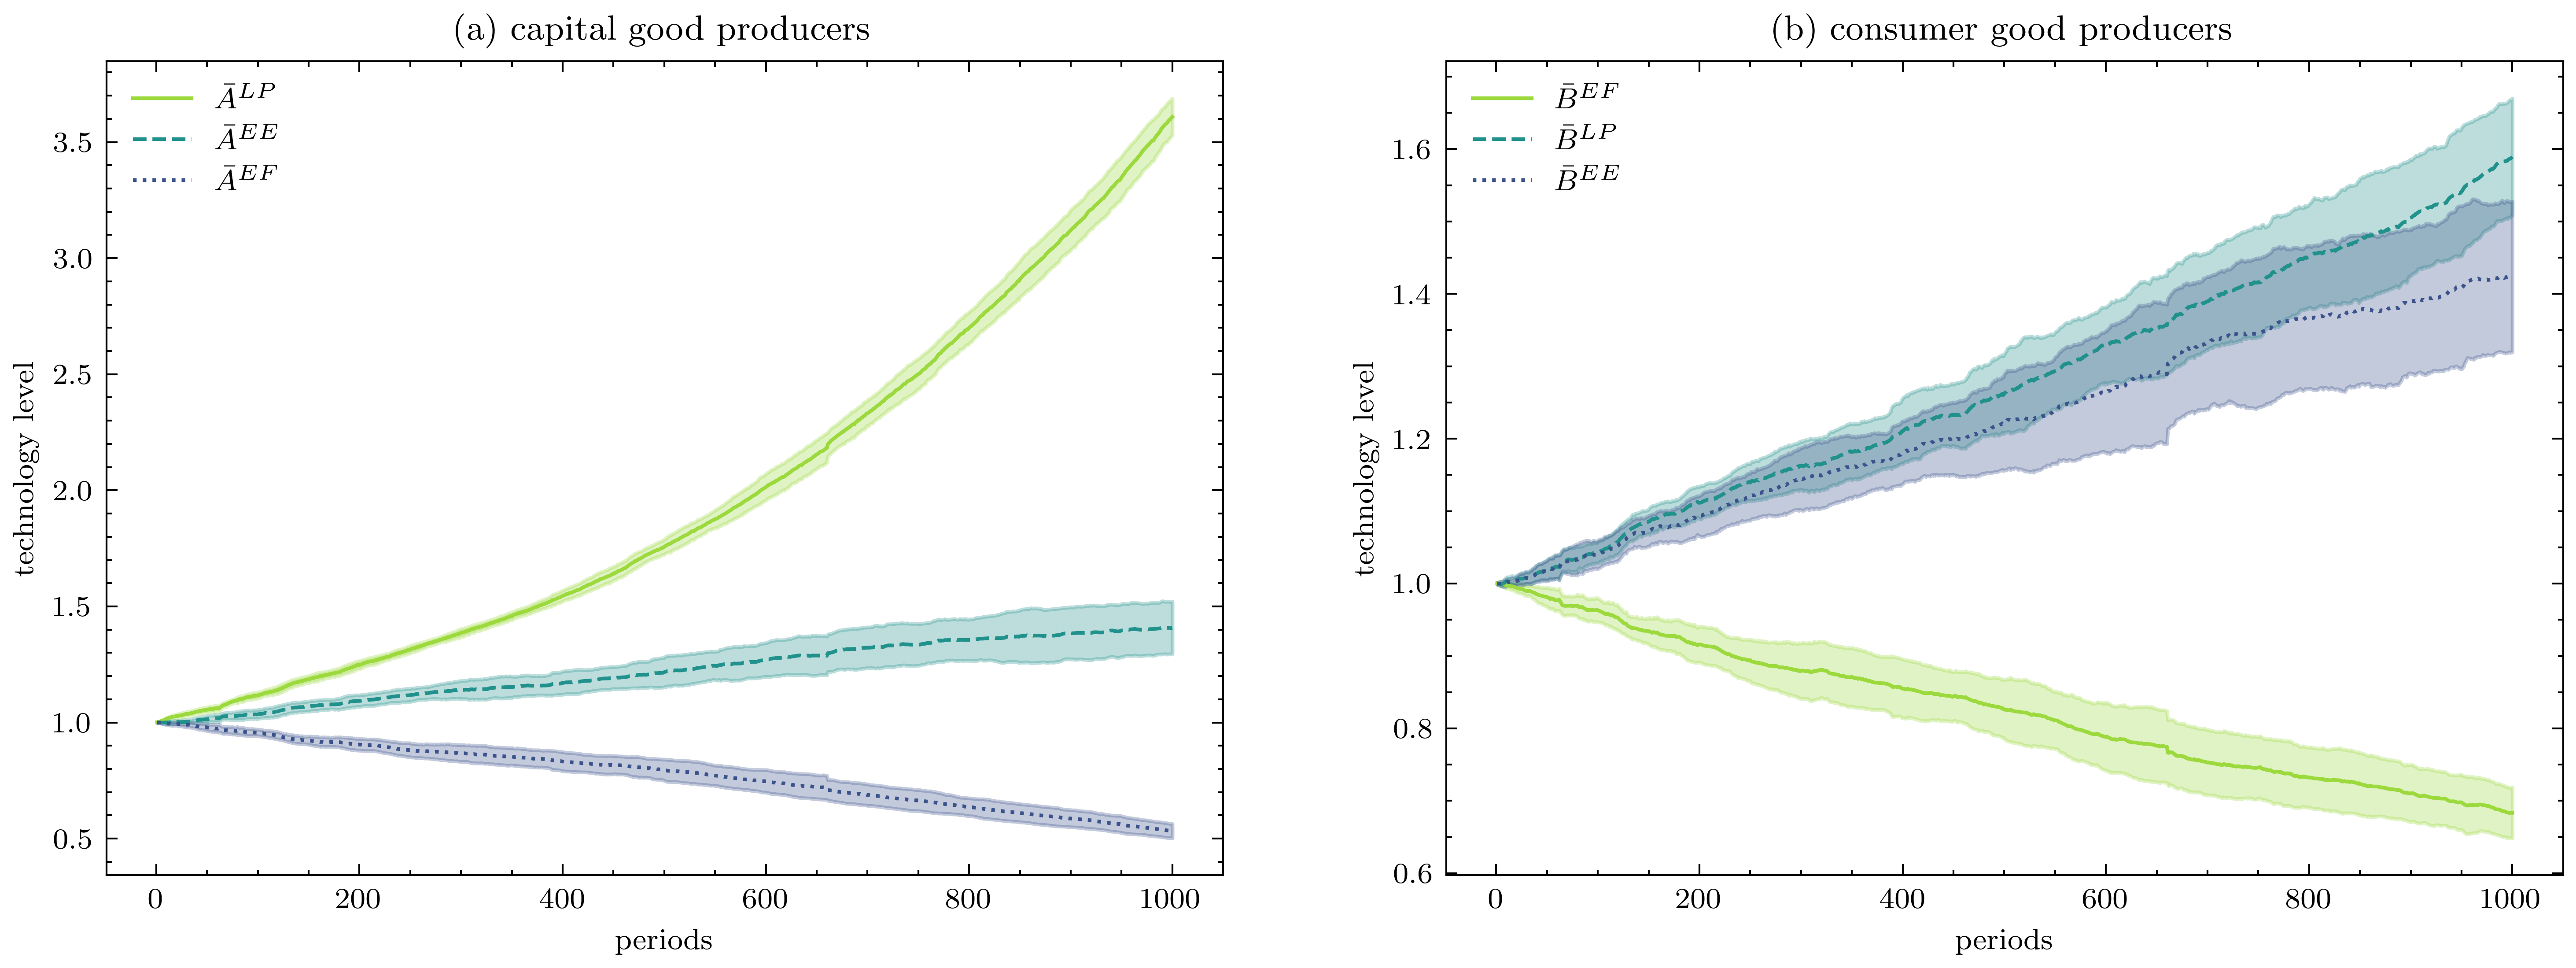

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap

#plt.style.use(['science','ieee'])
#plt.tight_layout()
custom_cmap = get_cmap('viridis')

def raw_stats(colstart, dataframe):
    cols = [col for col in dataframe.columns if col.startswith(colstart)]
    group_by_timestamp = dataframe.groupby('timestamp')[cols]
    ts_mean = group_by_timestamp.mean().mean(axis=1)
    ts_std = group_by_timestamp.std().mean(axis=1)
    return ts_mean, ts_std

# Create subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

# Plot for A_ variables (Consumer good producers on the left)
for colstart, color, label in zip(['A_LP', 'A_EE', 'A_EF'], [0.85, 0.5, 0.25], ['$\\bar{A}^{LP}$', '$\\bar{A}^{EE}$', '$\\bar{A}^{EF}$']):
    ts_mean, ts_std = raw_stats(colstart, df_concatenated1)
    ax1.plot(ts_mean, color=custom_cmap(color), label=label)
    ax1.fill_between(ts_mean.index, ts_mean - ts_std, ts_mean + ts_std, alpha=0.3, color=custom_cmap(color))

ax1.legend(loc='upper left')
ax1.set_xlabel('periods')
ax1.set_ylabel('technology level')
ax1.set_title('(a) Consumer good producers')

# Plot for B_ variables (Capital good producers on the right)
for colstart, color, label in zip(['B_EF', 'B_LP', 'B_EE'], [0.85, 0.5, 0.25], ['$\\bar{B}^{EF}$', '$\\bar{B}^{LP}$', '$\\bar{B}^{EE}$']):
    ts_mean, ts_std = raw_stats(colstart, df_concatenated1)
    ax2.plot(ts_mean, color=custom_cmap(color), label=label)
    ax2.fill_between(ts_mean.index, ts_mean - ts_std, ts_mean + ts_std, alpha=0.3, color=custom_cmap(color))

ax2.legend(loc='upper left')
ax2.set_xlabel('periods')
ax2.set_ylabel('technology level')
ax2.set_title('(b) capital good producers')

#plt.tight_layout()
plt.show()


In [32]:
import os


# Specify the folder where the CSV files are located
folder_path = "Firm_2"  # Replace with your actual folder path

# List all files in the specified folder
all_files = os.listdir(folder_path)

# Filter out files whose names contain 'kp_firm' and end with '.csv'
cp_firm_files = [f for f in all_files if 'cp_firm' in f and f.endswith('.csv')]

# Read these files into a list of DataFrames
dfs_filtered = [pd.read_csv(os.path.join(folder_path, f)) for f in cp_firm_files]

# Concatenate the filtered DataFrames along rows
df_concatenated = pd.concat(dfs_filtered, ignore_index=True)

#save aggregated data to csv
df_concatenated.to_csv('cp_firm_aggregated2.csv', index=False)

#show  last 100 rows of df_concatenated
df_concatenated.tail(100)



,cu,cp_i,possible_I,id,age,TCI,K,timestamp
1799900,0.163577,6.0,2749.981860,2623.0,3.0,1246.146179,3363.269686,1000
1799901,0.682159,1.0,10472.958270,2542.0,36.0,801.025895,10909.740384,1000
1799902,0.860782,5.0,10960.058109,2554.0,44.0,0.000000,6923.888634,1000
1799903,0.622758,7.0,21406.570813,2538.0,64.0,0.000000,6445.317251,1000
1799904,0.856629,10.0,12569.444065,2634.0,95.0,0.000000,10531.229200,1000
1799905,0.781086,2.0,6138.076377,2671.0,10.0,0.000000,6207.580407,1000
1799906,0.000000,1.0,14627.697207,2534.0,1.0,0.000000,0.000000,1000
1799907,0.871353,9.0,8245.742811,2518.0,14.0,0.000000,11423.083024,1000
1799908,0.425444,3.0,2309.010715,2622.0,7.0,0.000000,6444.241531,1000
1799909,0.835391,2.0,6283.310844,2639.0,28.0,112.309319,11680.443919,1000


/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_49447/2877917351.py:24: RuntimeWarning: invalid value encountered in divide
  I_ratio = I_month / K_month
/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_49447/2877917351.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = get_cmap('viridis')


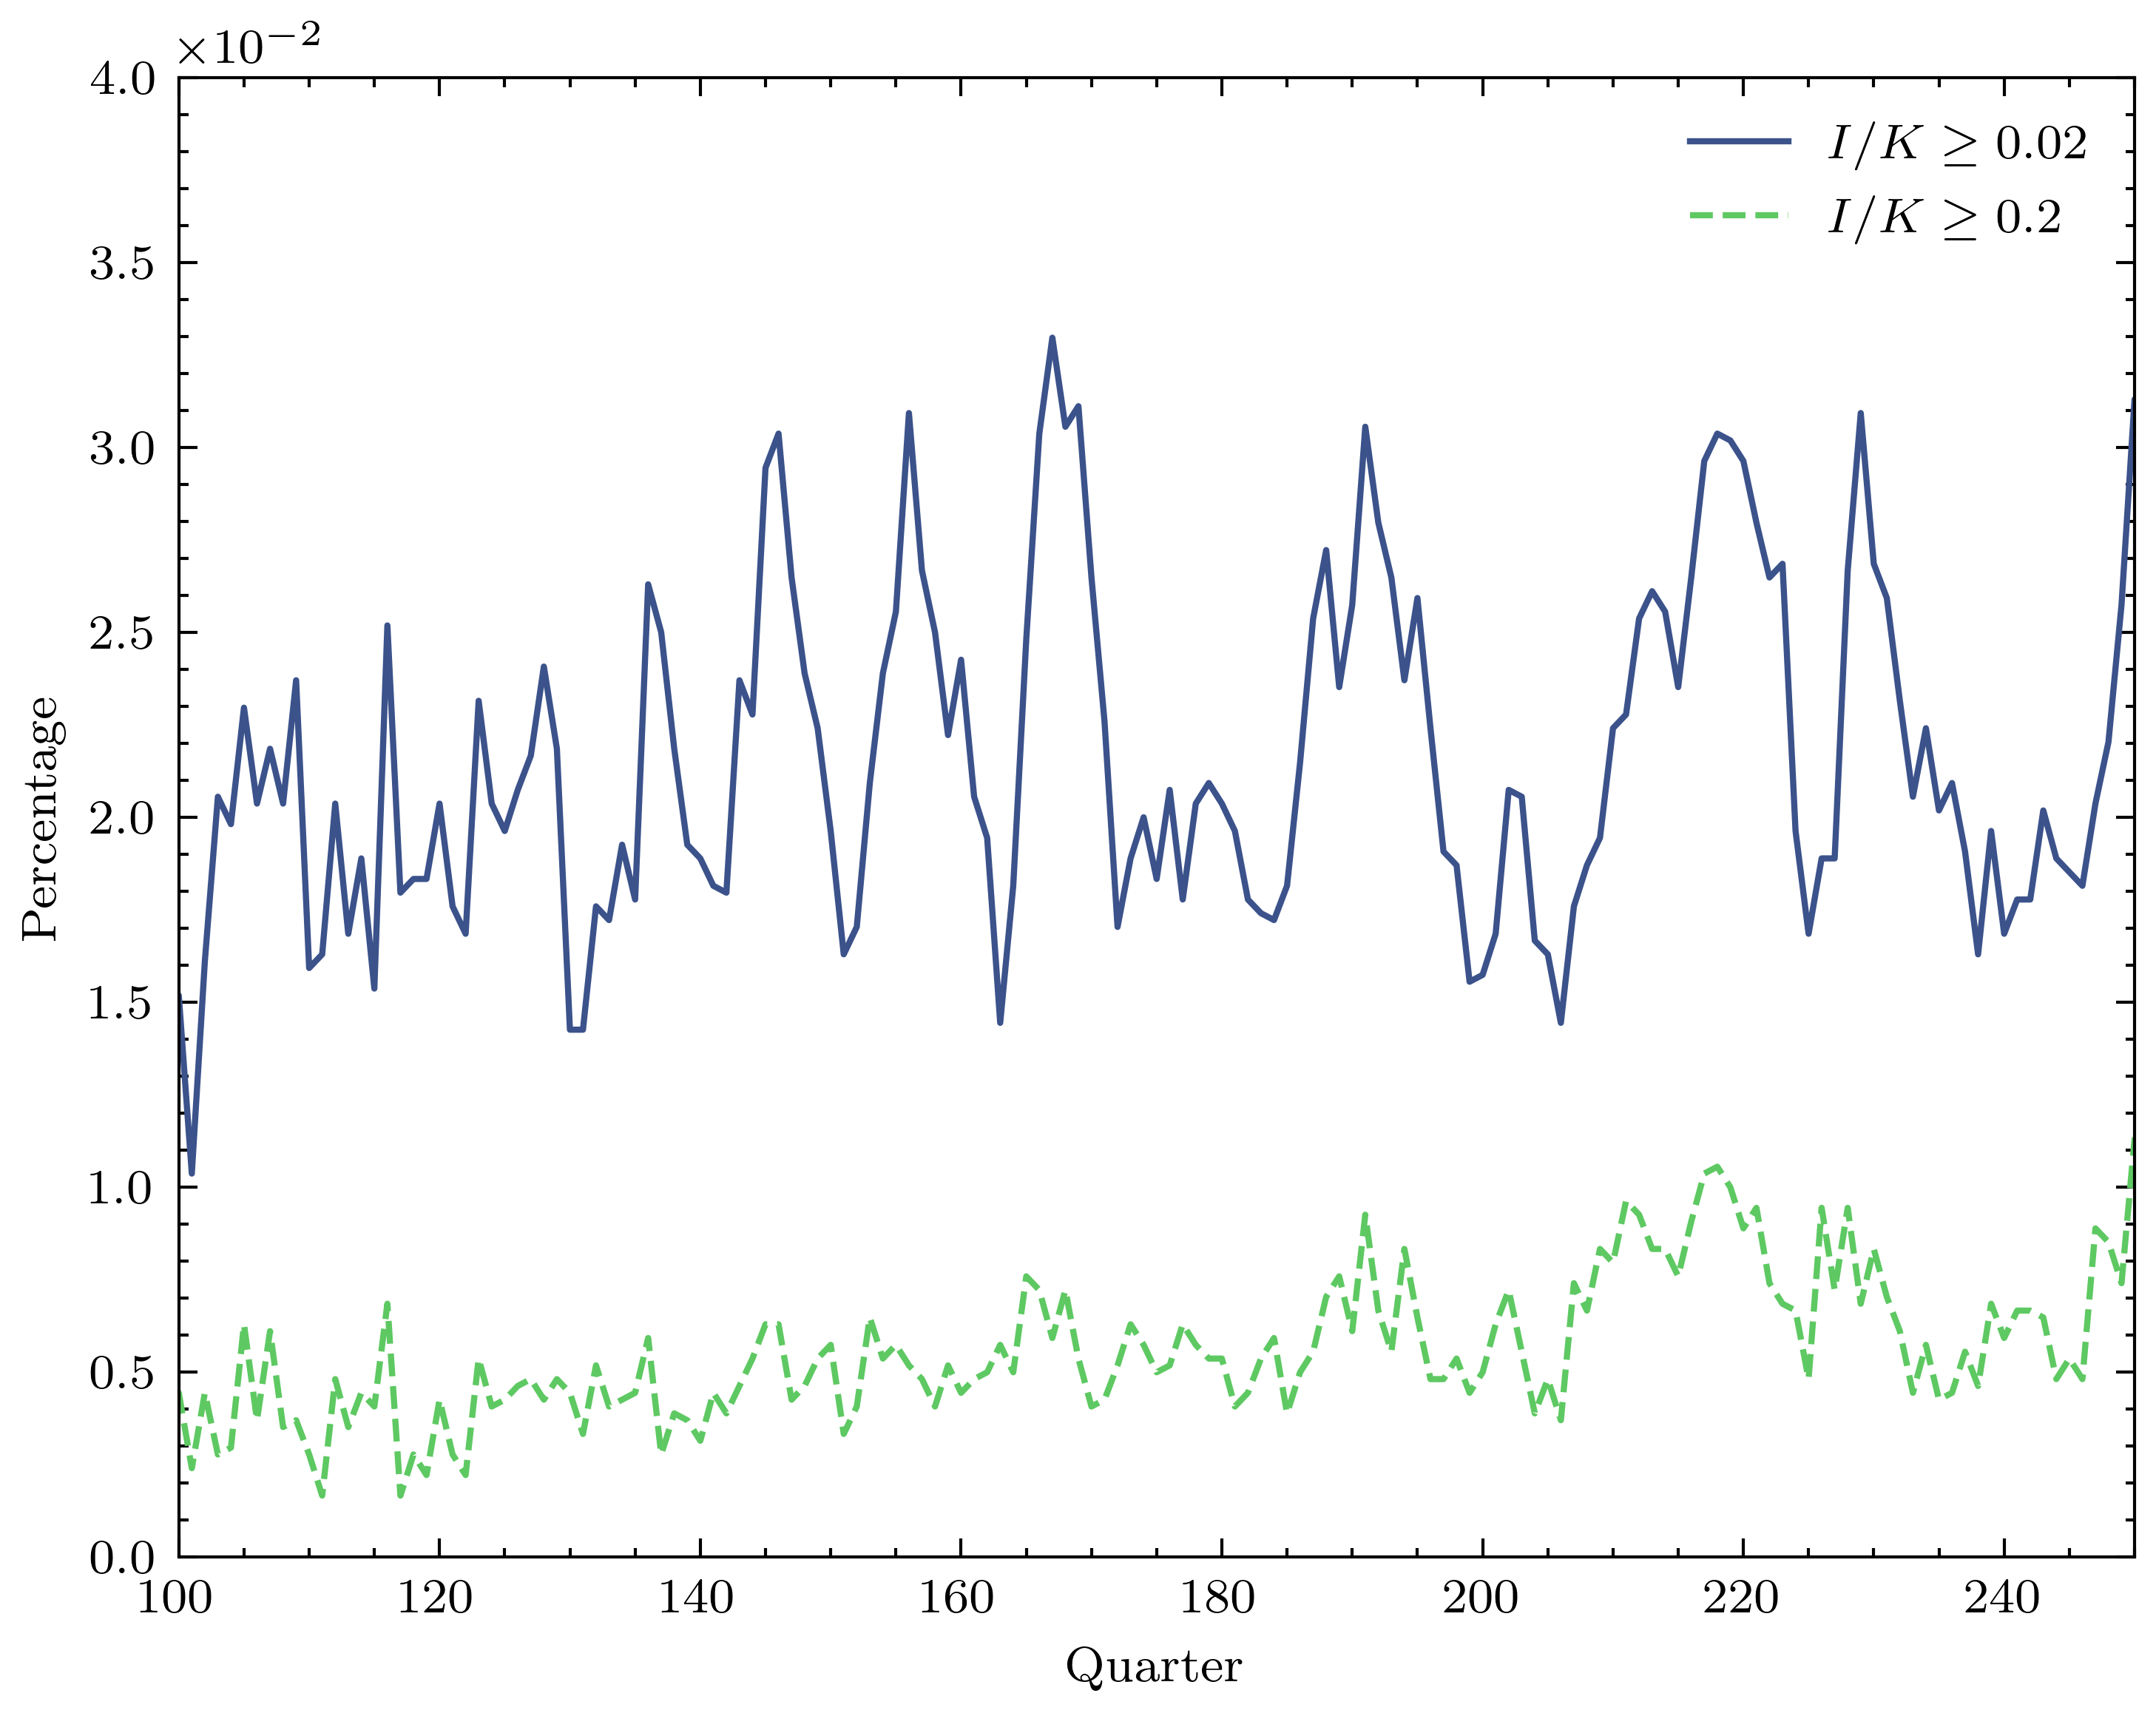

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
#import FormatStrFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter

# Load and sort data by timestamp
data_path_aggregated = 'Firm_2/2345_cp_firm.csv'
df_aggregated = pd.read_csv(data_path_aggregated).sort_values(by=['timestamp'])

# Extract columns related to TCI and K
I_cols = [col for col in df_aggregated.columns if col.startswith("TCI")]
K_cols = [col for col in df_aggregated.columns if col.startswith("K")]

# Check for required columns
if not I_cols or not K_cols:
    raise ValueError("Required columns missing. Check if 'TCI' and 'K' columns exist.")

# Calculate monthly I/K ratios
I_month = df_aggregated[I_cols].to_numpy()
K_month = df_aggregated[K_cols].to_numpy()
I_ratio = I_month / K_month

# Identify conditions for I_ratio
I_ratio_02 = np.where(I_ratio >= 0.2, 1, 0)
I_ratio_002 = np.where(I_ratio >= 0.02, 1, 0)

# Aggregate data quarterly
step_size = 3 * 200  # 3 timesteps multiplied by entries per timestep
I_ratio_quarterly_02 = np.array([np.sum(I_ratio_02[i:i+step_size, :], axis=0) for i in np.arange(0, I_ratio_02.shape[0], step=step_size)]) / (1800 * 3)
I_ratio_quarterly_002 = np.array([np.sum(I_ratio_002[i:i+step_size, :], axis=0) for i in np.arange(0, I_ratio_002.shape[0], step=step_size)]) / (1800 * 3)

# Plotting setup
custom_cmap = get_cmap('viridis')
plt.style.use(['science', 'ieee'])
fig, ax1 = plt.subplots(figsize=(5, 4))

# Create the plot
ax1.plot(np.sum(I_ratio_quarterly_002, axis=1), label='$I/K \geq 0.02$', color=custom_cmap(0.25))
ax1.plot(np.sum(I_ratio_quarterly_02, axis=1), label='$I/K \geq 0.2$', color=custom_cmap(0.75))

# Customize plot
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Percentage')
ax1.legend(loc='upper right')
#limit x axist from 200 to end
ax1.set_xlim(100, 250)
#put ylim to 0 to 0.04
ax1.set_ylim(0, 0.04)
# Set y-axis to scientific notation
formatter = ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
ax1.yaxis.set_major_formatter(formatter)
# Show the plot
plt.tight_layout()
plt.show()




In [309]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import get_cmap

# Include scientific plot style
plt.style.use(['science', 'ieee'])
def get_extrema(ax, x_interval):

    min_y, max_y = float('inf'), float('-inf')
    for line in ax.get_lines():
        xdata, ydata = line.get_data()
        f = lambda x: np.interp(x, xdata, ydata)
        
        # Find maximum y-value within the x-interval for this line
        result_max = minimize_scalar(lambda x: -f(x), bounds=x_interval, method='bounded')
        max_y = max(max_y, -result_max.fun)
        
        # Find minimum y-value within the x-interval for this line
        result_min = minimize_scalar(f, bounds=x_interval, method='bounded')
        min_y = min(min_y, result_min.fun)
        #extra 80% of y value
        print(min_y, max_y)
        min_y = min_y + 0.2 * min_y
        max_y = max_y + 0.3 * max_y
        print(min_y, max_y)
    return min_y, max_y

# Function to add inset for given axes
def add_inset(ax, df, cols, colors, xlim, ylim):
    axins = inset_axes(ax, width="30%", height="20%", loc=4,
                       bbox_to_anchor=(0, 0, 1, 1),
                       bbox_transform=ax.transAxes)
    for idx, col in enumerate(cols):
        axins.plot(df.index, df[col], color=colors[idx])
    axins.set_xlim(xlim)
    axins.set_ylim(ylim)

# Modified function to plot the percentage change in value for income
def plot_income(df, relevant_income_columns, ax):
    custom_cmap = get_cmap('viridis')
    colors = [custom_cmap(x) for x in [0.1, 0.5, 0.9]]
    share = len(relevant_income_columns)

    df_rel_change_income = df[relevant_income_columns].pct_change() * 100  # Calculate percentage change

    for idx, col in enumerate(relevant_income_columns):
        ax.plot(df.index, df_rel_change_income[col], label=col , color=custom_cmap(idx/share))

    ax.set_xlim(280, 350)
    ymin, ymax = get_extrema(ax, (280, 350))
    ax.set_ylim(ymin, ymax)

    ax.set_title('Percentage Change in Thresholds of Income Percentiles')
    ax.set_xlabel('Time')
    ax.set_ylabel('Percentage Change in Income')
    ax.legend()

# Modified function to plot the percentage change in value for wealth
def plot_wealth(df, relevant_wealth_columns):
    custom_cmap = get_cmap('viridis')
    colors = [custom_cmap(x) for x in [0.1, 0.5, 0.9]]
    share = len(relevant_wealth_columns)

    df_rel_change_wealth = df[relevant_wealth_columns].pct_change() * 100  # Calculate percentage change
    fig, ax = plt.subplots(figsize=(4, 3))
    for idx, col in enumerate(relevant_wealth_columns):

        ax.plot(df.index, df_rel_change_wealth[col], label=col, color=custom_cmap(idx/share))
    
    #ax.set_xlim(280, 350)
    #ymin, ymax = get_extrema(ax, (280, 350))
    #add/subtract 10% of y value to ymin/ymax


    #ymin, ymax = (-8, 8)
    #ax.set_ylim(ymin, ymax)

    ax.set_title('Percentage Change of Wealth Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel('Percentage Change in Wealth')
    ax.legend( loc='upper left')
    
    ymin, ymax = ax.get_ylim()
    #add_inset(ax, df_rel_change_wealth, relevant_wealth_columns, colors, xlim=(300, 350), ylim=(ymin, ymax))
    plt.tight_layout()
    plt.show()

# #Example usage
# #Load the DataFrame (assuming you have a CSV file named '1234_model.csv')
# df = pd.read_csv('1234_model.csv')

# #Define the relevant columns for income and wealth
# relevant_income_columns = ['I_20', 'I_80', 'I_min']
# relevant_wealth_columns = ['W_20', 'W_80', 'W_min']

# #Check if both sets of relevant columns are present in the DataFrame
# if set(relevant_income_columns).issubset(df.columns) and set(relevant_wealth_columns).issubset(df.columns):
#     plot_income(df, relevant_income_columns)
#     plot_wealth(df, relevant_wealth_columns)
# else:
#     print("Specified columns not found in the dataset.")



/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_96944/3814630480.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = get_cmap('viridis')
/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_96944/3814630480.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = get_cmap('viridis')


-3.855234118971608 2.247576087656535
-4.62628094276593 2.9218489139534953
-4.62628094276593 2.9218489139534953
-5.551537131319115 3.7984035881395437
-5.551537131319115 3.7984035881395437
-6.661844557582938 4.9379246645814066
-6.661844557582938 4.9379246645814066
-7.994213469099526 6.419302063955828
-28.038450396818163 12.075598036843182
-33.6461404761818 15.698277447896137
-33.6461404761818 15.698277447896137
-40.37536857141816 20.40776068226498
-40.37536857141816 20.40776068226498
-48.45044228570179 26.530088886944473
-53.67727477844912 26.530088886944473
-64.41272973413894 34.489115553027816


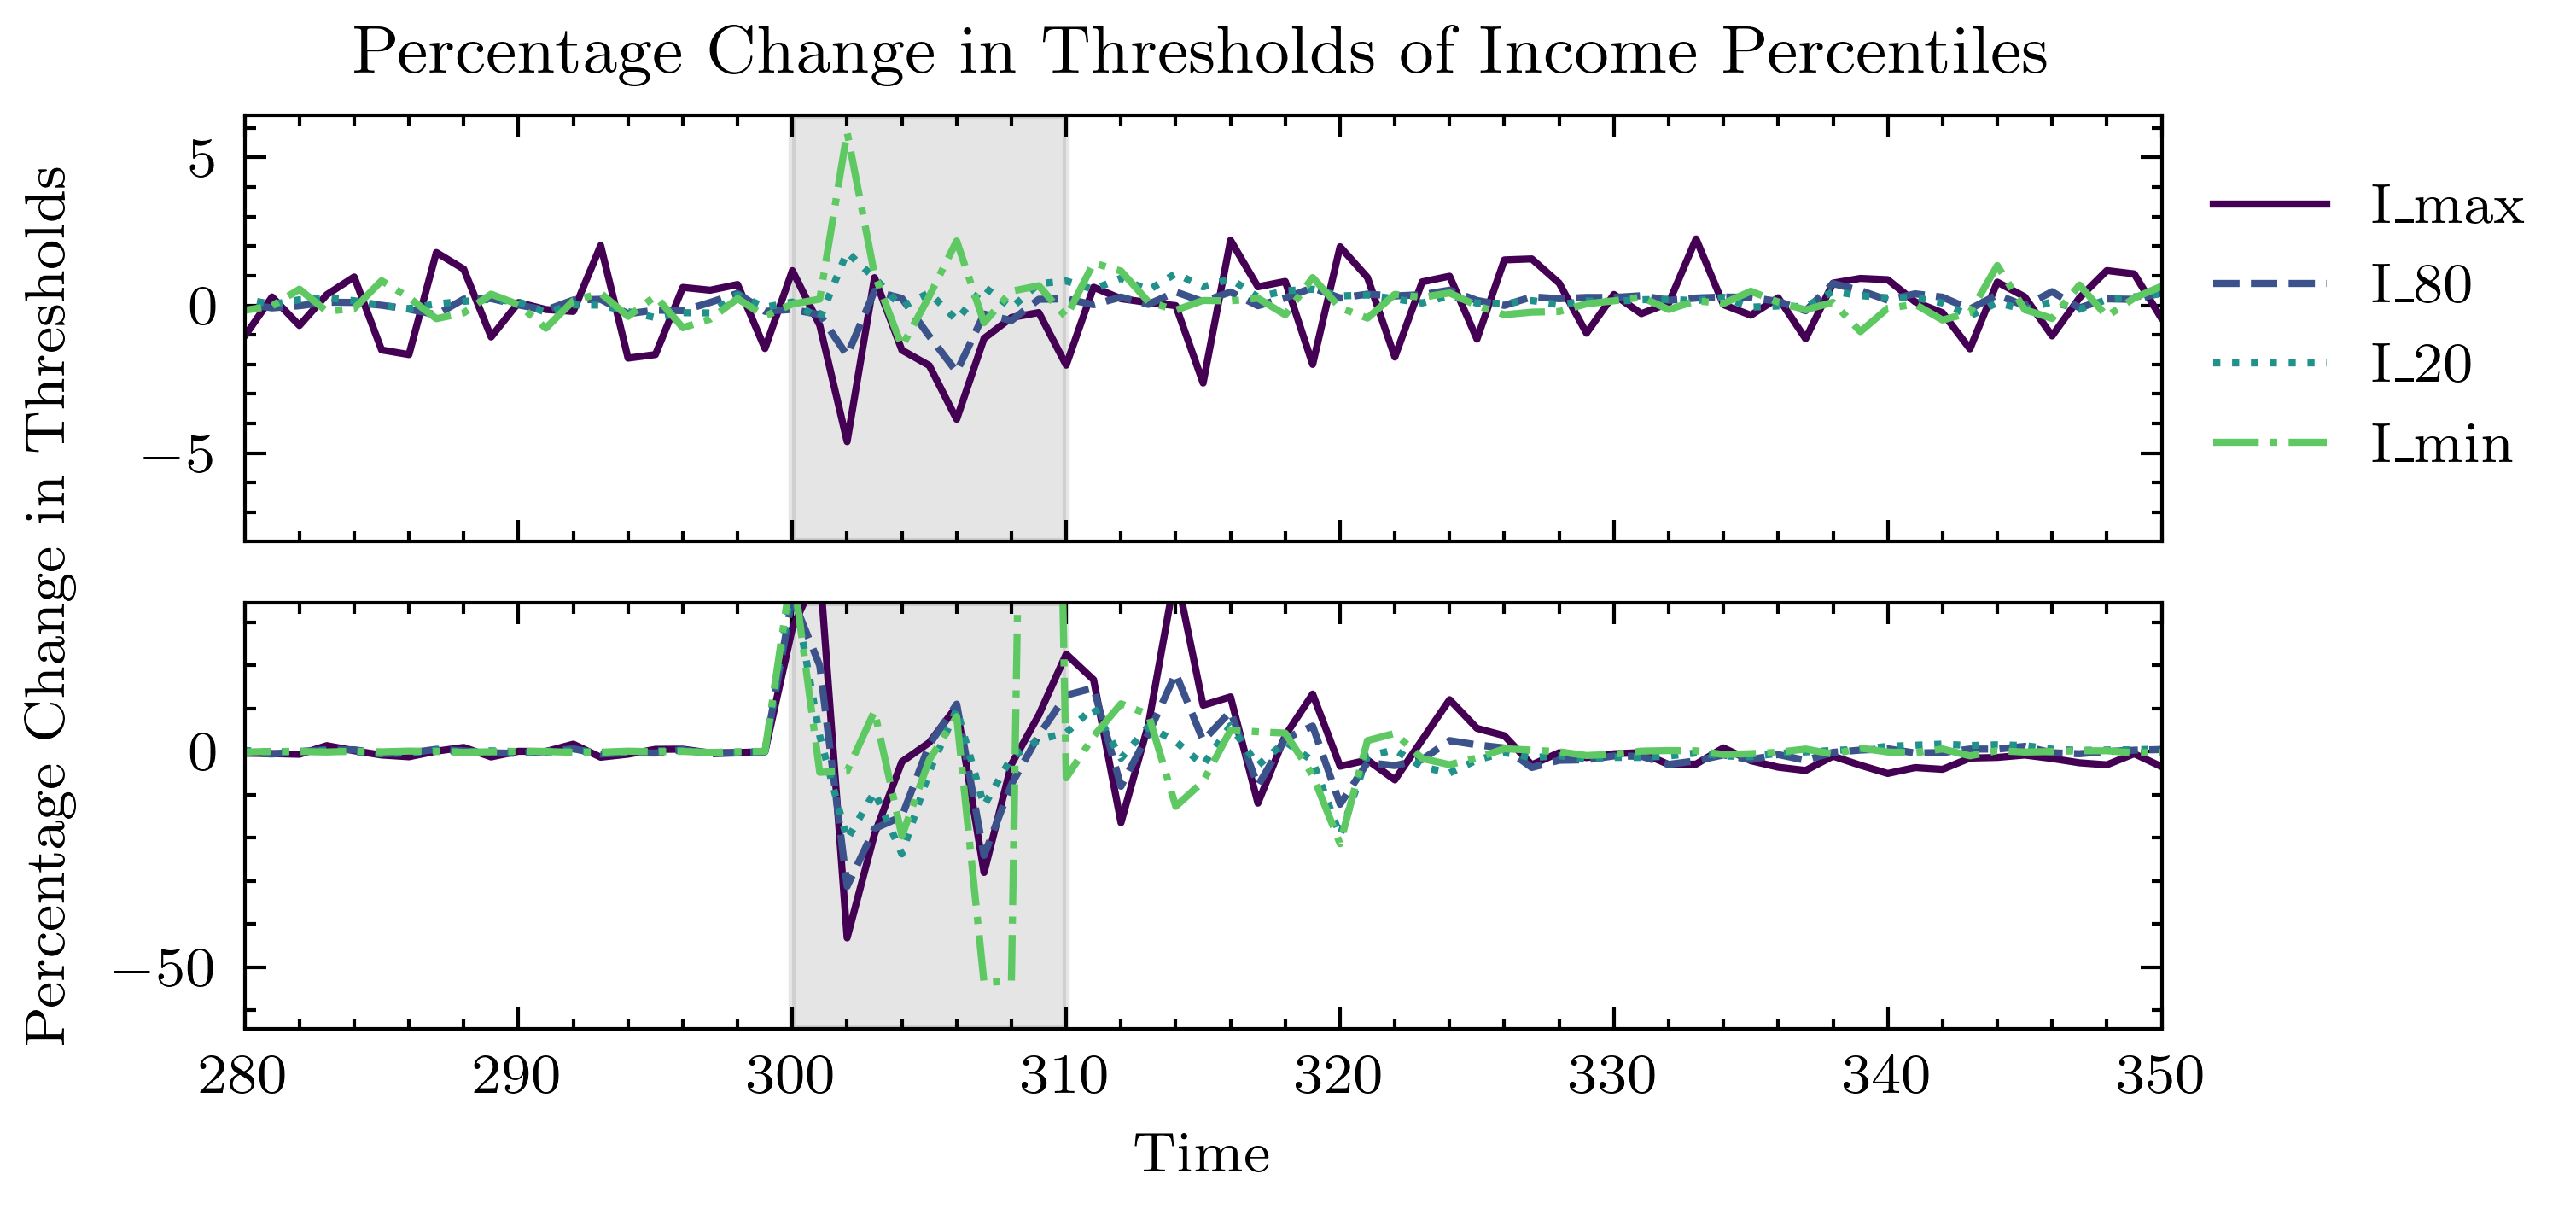

In [312]:
import pandas as pd
import numpy as np
import glob

def read_csv_files(file_paths):
    """
    Read multiple CSV files and return a list of DataFrames.
    
    Parameters:
    - file_paths (list): List of paths to the CSV files.
    
    Returns:
    - dataframes (list): List of DataFrames.
    """
    return [pd.read_csv(file_path) for file_path in file_paths]

def average_and_confidence_bands(dataframes, relevant_columns):
    # Concatenate the DataFrames along a new axis to create a 3D array
    data_3D = np.stack([df[relevant_columns].values for df in dataframes])
    
    # Calculate the mean along the first axis (axis=0) to average over runs
    mean_values = np.mean(data_3D, axis=0)
    
    # Calculate the standard deviation along the first axis (axis=0)
    std_values = np.std(data_3D, axis=0, ddof=1)
    
    # Calculate the confidence interval (95%)
    conf_interval = 1.96 * (std_values / np.sqrt(len(dataframes)))
    
    # Calculate the lower and upper bounds of the confidence interval
    lower_bounds = mean_values - conf_interval
    upper_bounds = mean_values + conf_interval
    
    # Convert to DataFrames
    avg_df = pd.DataFrame(mean_values, columns=relevant_columns)
    lower_conf_df = pd.DataFrame(lower_bounds, columns=relevant_columns)
    upper_conf_df = pd.DataFrame(upper_bounds, columns=relevant_columns)
    
    return avg_df, lower_conf_df, upper_conf_df


def data_manager(file_paths):
    # List all CSV files containing the data from each run
    # Assume the files are named as run1.csv, run2.csv, etc.
    
    # Read the CSV files into DataFrames
    dataframes = read_csv_files(file_paths)
    
    # Calculate the average and confidence bands
    relevant_columns = ['I_max', 'I_80','I_20', 'I_min','W_max',  'W_80','W_20', 'W_min']
    avg_df, lower_conf_df, upper_conf_df = average_and_confidence_bands(dataframes, relevant_columns)
    
    # Now, you can pass avg_df to plot_income and plot_wealth as needed

    return avg_df, lower_conf_df, upper_conf_df
fig, axs = plt.subplots(2, 1, figsize=(5, 2.5))


# For 25 Data
file_paths = glob.glob(os.path.join("25 Data", "*.csv"))
avg_df, lower_conf_df, upper_conf_df = data_manager(file_paths)
relevant_income_columns = ['I_max', 'I_80', 'I_20', 'I_min']
plot_income(avg_df, relevant_income_columns, axs[0])

# For 26 Data
file_paths = glob.glob(os.path.join("27 Data", "*.csv"))
avg_df, lower_conf_df, upper_conf_df = data_manager(file_paths)
plot_income(avg_df, relevant_income_columns, axs[1])

#delete axs[1] title
axs[1].set_title('')
#delete axs[0] xlabel
axs[0].set_xlabel('')
#delete axs[0] x axis numbers
axs[0].set_xticklabels([])
#delete axs[1] legend
axs[1].legend('')
#place axs[1] legend on the right and outside of plot
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#make both plots share one y label
fig.text(-0.01, 0.5, 'Percentage Change in Thresholds', va='center', rotation='vertical')
#delete both y axis labels
axs[0].set_ylabel('')
axs[1].set_ylabel('')
#add greyed out area for duration of shock periods 300-310
axs[0].axvspan(300, 310, alpha=0.2, color='grey')
axs[1].axvspan(300, 310, alpha=0.2, color='grey')


plt.tight_layout()
plt.show()







